In [1]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd # Data structures
import numpy as np # Matrix algebra
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters # Plotting
register_matplotlib_converters() # Plotting
import seaborn as sns # Plotting
import gc # Garbage collection

In [2]:
from platform import python_version
print('python version: ', python_version())
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)

python version:  3.7.4
numpy version:  1.19.2
pandas version:  0.25.3


In [3]:
### RUN EVERY TIME: MAIN CONSTANTS

### MultiIndex level slice constant:
All = slice(None)
### UN Comtrade aggregated data container with Acadian materials:
str_path_acadian = 'Data_Files/Source_Files/unc_res_subset.h5'
str_key_acadian = 'acadian'
### UN Comtrade aggregated data container with total countries trade:
str_path_global = 'Data_Files/Source_Files/unc_res_all_world.h5'
str_key_unc ='unc_res'
### Universe path:
str_path_universe = 'Data_Files/Source_Files/Universe.xlsx'
### Dates:
str_date_end = '2021-12-31'
### NA for MS Excel files:
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable', '---']
### Regions:
list_region = ['DM', 'EM', 'FM']

In [4]:
### DEFINING EXTRACTION ISON UNIVERSE DATA FROM MS EXCEL SOURCE

def ison_membership_converting(str_path_universe, date_end, bool_daily = False, int_backfill_months = 0):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(engine = 'openpyxl', io = str_path_universe, sheet_name = 'Switchers', header = 0, parse_dates = True, index_col = [0, 1],
                                    na_values = list_na_excel_values, keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index() 
    ### Expanding membership for primary regions members by backfilling:
    if int_backfill_months:
        ### List of regions:
        list_region = list(ser_res_universe.dropna().unique())
        ### Initialising of collection of series with backfilled data for each region:
        list_ison_backfill = []
        ### Regions looping:
        for iter_region in list_region:
            ### Defining start of region date:
            date_first_valid = ser_res_universe.loc[ser_res_universe == iter_region].first_valid_index()[0]
            ### Creating dates index to backfilling:
            idx_date_backfill = pd.date_range(end = date_first_valid, periods = int_backfill_months + 1, freq = 'BM')[: -1]
            ### Creating primary countries index to backfilling:            
            idx_region_backfill = ser_res_universe.loc[ser_res_universe == iter_region].loc[date_first_valid, All].index.get_level_values('Country')
            ### Creating full index:
            idx_ison_backfill = pd.MultiIndex.from_product([idx_date_backfill, idx_region_backfill])
            ### Series with backfilled data:
            list_ison_backfill.append(pd.Series(iter_region, index = idx_ison_backfill))
        ### Combination of backfilled series and original ISON data:    
        ser_res_universe = ser_res_universe.combine_first(pd.concat(list_ison_backfill, axis = 0)).sort_index()  
        ser_res_universe.index.names = ['Date', 'Country']
    ### Converting to daily frequency:
    if bool_daily:
        ser_res_universe = ser_res_universe.reset_index('Country').groupby('Country').resample('B').ffill()['Market'].swaplevel().sort_index()    
    ### Results output:
    ser_res_universe.name = 'Market'
    return ser_res_universe

In [5]:
### RUN EVERY TIME: ISON DATA EXTRACTION STEPS

### ISON membership history:
ser_ison_membership = ison_membership_converting(str_path_universe, pd.to_datetime(str_date_end))
### ISON country status on 2021-12-31:
ser_ison_status = ser_ison_membership.loc[str_date_end].droplevel('Date')
ser_ison_status.index.name = 'Reporter'

In [6]:
### DEFINING DATA EXTRACTION PROCEDURE

def get_comtrade_data(str_comtrade_id = None, # Use UN Comtrade HS 1992 Commodity ID i.e '2711'
                      str_flow = None, # Use 'Export' or 'Import'
                      str_start_year = None, # Use 'YYYY' format i.e. '1994'
                      str_end_year = None, # Use 'YYYY' format i.e. '2015'
                      str_reporter = None, # Use ISO short codes for countries i.e. 'US'
                      str_partner = None, # Use 'World' for World and ISO short codes for countries i.e. 'US'
                      str_name = None, # Use commodity code from concordance spreadsheet i.e. 'Cattle'
                      str_flag = None # Use 0 for those commodities that don't have AG6 alternative, 1 - for AG2/AG4 alternative, 2 - for AG6 alternative
                     ):
    ### Request parameters preparation:
    dict_conditions = {}
    if (str_comtrade_id is not None):        
        dict_conditions['Commodity_ID'] = 'str_comtrade_id'
    else:
        dict_conditions['Commodity_ID'] = None     
    if (str_flow is not None):        
        dict_conditions['Flow'] = 'str_flow'
    else:
        dict_conditions['Flow'] = None           
    if (str_start_year is not None):
        str_start_date = (pd.to_datetime(str_start_year) + pd.offsets.BYearEnd()).strftime('%Y-%m-%d')
    else:
        str_start_date = '1981-12-31'
    if (str_end_year is not None):
        str_end_date = (pd.to_datetime(str_end_year) + pd.offsets.BYearEnd()).strftime('%Y-%m-%d')
    else:
        str_end_date = '2020-12-31'
    if (str_reporter is not None):        
        dict_conditions['Reporter'] = 'str_reporter'
    else:
        dict_conditions['Reporter'] = None           
    if (str_partner is not None):        
        dict_conditions['Partner'] = 'str_partner'
    else:
        dict_conditions['Partner'] = None           
    if (str_name is not None):        
        dict_conditions['Commodity_Name'] = 'str_name'
    else:
        dict_conditions['Commodity_Name'] = None           
    if (str_flag is not None):        
        dict_conditions['Flag'] = 'str_flag'
    else:
        dict_conditions['Flag'] = None           
        
    if ((str_start_date == '1981-12-31') & (str_end_date == '2020-12-31')):
        list_filter = []
    else:
        list_filter = ['(Date >= str_start_date) & (Date <= str_end_date)']
    ### Request constructing:
    for iter_level in dict_conditions:
        if (dict_conditions[iter_level] is not None):
            list_filter.append('(' + iter_level + ' in ' + dict_conditions[iter_level] + ')')
    print(' & '.join(list_filter))
    ### Request implementing:
    ser_res = pd.read_hdf(path_or_buf = str_path_acadian, key = str_key_acadian, where = ' & '.join(list_filter)).sort_index()
    return ser_res        

In [7]:
### EXAMPLE #1: REQUEST FROM DATAFILE BY FUNCTION WITHOUT LISTS AS PARAMETERS

gc.collect()
display(get_comtrade_data(str_flow = 'Export', 
                          str_partner = 'World', 
                          str_comtrade_id = '18',
                          str_reporter = 'IS', 
#                          str_flag = 0, 
#                          str_name = 'Zinc', 
                          str_start_year = '2015', 
                          str_end_year = '2018'))

(Date >= str_start_date) & (Date <= str_end_date) & (Commodity_ID in str_comtrade_id) & (Flow in str_flow) & (Reporter in str_reporter) & (Partner in str_partner)


Date        Reporter  Partner  Flow    Commodity_ID  Commodity_Name  Flag
2015-12-31  IS        World    Export  18            Cocoa           0       2077485
2016-12-30  IS        World    Export  18            Cocoa           0       2774695
2017-12-29  IS        World    Export  18            Cocoa           0       2258192
2018-12-31  IS        World    Export  18            Cocoa           0       2440957
Name: Value, dtype: int64

In [8]:
### EXAMPLE #2: REQUEST FROM DATAFILE BY FUNCTION WITH LISTS AS PARAMETERS

gc.collect()
display(get_comtrade_data(str_flow = 'Export', 
                          str_partner = ['US', 'World'], 
                          str_comtrade_id = ['17', '18', '0901'],
                          str_reporter = 'IS', 
                          str_flag = [0, 1], 
#                          str_name = 'Zinc', 
                          str_start_year = '2015', 
                          str_end_year = '2018'))

(Date >= str_start_date) & (Date <= str_end_date) & (Commodity_ID in str_comtrade_id) & (Flow in str_flow) & (Reporter in str_reporter) & (Partner in str_partner) & (Flag in str_flag)


Date        Reporter  Partner  Flow    Commodity_ID  Commodity_Name  Flag
2015-12-31  IS        US       Export  0901          Coffee          0           164
                                       17            Sugar           0         41439
                                       18            Cocoa           0        740407
                      World    Export  0901          Coffee          0         65402
                                       17            Sugar           0        381096
                                       18            Cocoa           0       2077485
2016-12-30  IS        US       Export  0901          Coffee          0           540
                                       17            Sugar           0         42383
                                       18            Cocoa           0        903555
                      World    Export  0901          Coffee          0         61406
                                       17            Sugar           0      

In [9]:
### EXAMPLE #3: DIRECT REQUEST FROM DATAFILE

gc.collect()
str_where = "(Commodity_ID == '79') & (Reporter = 'IS') & (Partner = ['US', 'World']) & (Date >= '2018-12-31') & (Flow in ['Import'])"
display(pd.read_hdf(path_or_buf = str_path_acadian, key = str_key_acadian, where = str_where))

Date        Reporter  Partner  Flow    Commodity_ID  Commodity_Name  Flag
2018-12-31  IS        US       Import  79            Zinc            0          5091
2019-12-31  IS        US       Import  79            Zinc            0          4912
2020-12-31  IS        US       Import  79            Zinc            0         18787
2021-12-31  IS        US       Import  79            Zinc            0          3745
2018-12-31  IS        World    Import  79            Zinc            0       1154150
2019-12-31  IS        World    Import  79            Zinc            0        973308
2020-12-31  IS        World    Import  79            Zinc            0        876645
2021-12-31  IS        World    Import  79            Zinc            0        885630
Name: Value, dtype: int64

In [10]:
### STATS: EXPORT COVERAGE: DATA LOADING

gc.collect()
### Bilateral data only:
df_comm_full = get_comtrade_data(str_flow = 'Export', str_flag = [0, 1]).reset_index()
df_comm_full = df_comm_full[df_comm_full['Partner'] != 'World']
### Total trading:
df_comm_world = get_comtrade_data(str_flow = 'Export', str_flag = [0, 1], str_partner = 'World').reset_index()
ser_ison_status.index.name = 'Reporter'

(Flow in str_flow) & (Flag in str_flag)
(Flow in str_flow) & (Partner in str_partner) & (Flag in str_flag)


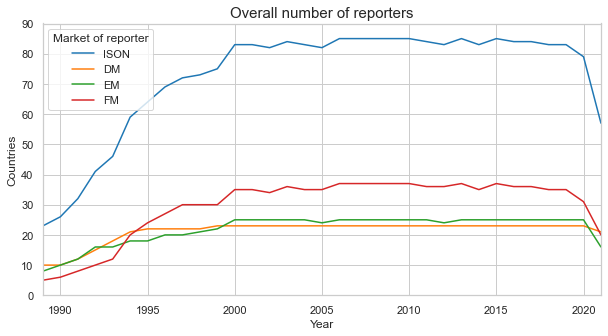

In [11]:
### STATS: EXPORT COVERAGE: REPORTERS NUMBER

### Joining regions of reporters and partners:
df_coverage_full = df_comm_full.join(ser_ison_status, on = 'Reporter', rsuffix = '_Reporter').join(ser_ison_status, on = 'Partner', rsuffix = '_Partner')
df_coverage_full.rename({'Market': 'Reporter_Market', 'Market_Partner': 'Partner_Market'}, axis = 1, inplace = True)
### Reporters number calculation start:
dict_reporters = {}
### Total reporters number:
ser_iter_reporters = df_coverage_full.groupby('Date')['Reporter'].apply(lambda ser_date: len(ser_date.unique()))
ser_iter_reporters.name = 'Number'
dict_reporters['ISON']  = ser_iter_reporters
### Region's reporters number:
for iter_region in list_region:
    ser_iter_reporters = df_coverage_full[df_coverage_full['Reporter_Market'] == iter_region]\
                            .groupby('Date')['Reporter'].apply(lambda ser_date: len(ser_date.unique()))
    ser_iter_reporters.name = 'Number'
    dict_reporters[iter_region]  = ser_iter_reporters
### Data consolidating:    
df_reporters = pd.concat(dict_reporters, axis = 0).reset_index()
df_to_plot = df_reporters.rename({'level_0': 'Market of reporter'}, axis = 1)
df_to_plot['Year'] = df_to_plot['Date'].dt.year
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_reporters = sns.lineplot(data = df_to_plot, x = 'Year', y = 'Number', hue = 'Market of reporter')
ax_reporters.set_title('Overall number of reporters', fontsize = 15)
ax_reporters.set(xlim = (1989, 2021), ylim = (0, 90), ylabel = 'Countries')
plt.show()

In [12]:
get_comtrade_data(str_flow = 'Export', 
                          str_partner = ['World'], 
                          #str_comtrade_id = ['17', '18', '0901'],
                          #str_reporter = 'IS', 
                          str_flag = [0, 1], 
#                         str_name = 'Zinc', 
                          str_start_year = '1991', 
                          str_end_year = '1991').reset_index()['Reporter'].unique().to_list()

(Date >= str_start_date) & (Date <= str_end_date) & (Flow in str_flow) & (Partner in str_partner) & (Flag in str_flag)


['AE',
 'AU',
 'BD',
 'BR',
 'CA',
 'CH',
 'CL',
 'CO',
 'CY',
 'DE',
 'DK',
 'EC',
 'ES',
 'FI',
 'ID',
 'IN',
 'IS',
 'JP',
 'KR',
 'LK',
 'MX',
 'MY',
 'NZ',
 'OM',
 'PT',
 'RO',
 'SA',
 'SG',
 'TH',
 'TN',
 'TR',
 'US']

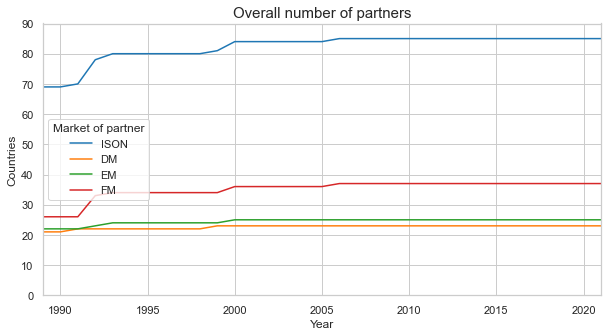

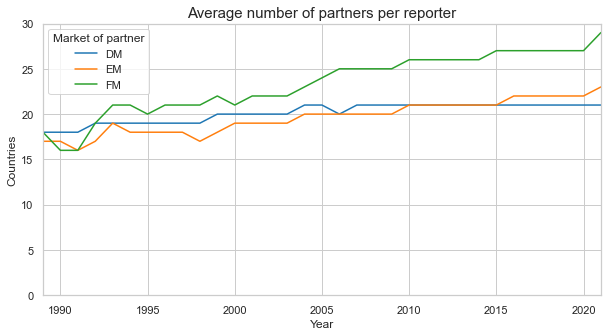

In [13]:
### STATS: EXPORT COVERAGE: PARTNERS NUMBER

### Adding regions of reporters and partners:
df_coverage_full = df_comm_full.join(ser_ison_status, on = 'Reporter', rsuffix = '_Reporter').join(ser_ison_status, on = 'Partner', rsuffix = '_Partner')
df_coverage_full.rename({'Market': 'Reporter_Market', 'Market_Partner': 'Partner_Market'}, axis = 1, inplace = True)
### Partners number calculation start:
dict_partners = {}
### Total partners number:
ser_iter_partners = df_coverage_full.groupby('Date')['Partner'].apply(lambda ser_date: len(ser_date.unique()))
ser_iter_partners.name = 'Number'
### Region's partners number:
dict_partners['ISON']  = ser_iter_partners
for iter_region in list_region:
    ser_iter_partners = df_coverage_full[df_coverage_full['Partner_Market'] == iter_region]\
                            .groupby('Date')['Partner'].apply(lambda ser_date: len(ser_date.unique()))
    ser_iter_partners.name = 'Number'
    dict_partners[iter_region]  = ser_iter_partners
### Data consolidating:        
df_partners = pd.concat(dict_partners, axis = 0).reset_index()
df_to_plot = df_partners.rename({'level_0': 'Market of partner'}, axis = 1)
df_to_plot['Year'] = df_to_plot['Date'].dt.year
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_partners = sns.lineplot(data = df_to_plot, x = 'Year', y = 'Number', hue = 'Market of partner')
ax_partners.set_title('Overall number of partners', fontsize = 15)
ax_partners.set(xlim = (1989, 2021), ylim = (0, 90), ylabel = 'Countries')
plt.show()



### Average partners number calculation start:
dict_ave_partners = {}
### Region's partners average number:
for iter_region in list_region:
    ser_iter_partners = df_coverage_full[df_coverage_full['Partner_Market'] == iter_region]\
                                .groupby(['Date', 'Reporter'])['Partner'].apply(lambda ser_date: len(ser_date.unique())).groupby('Date').mean().astype(int)
    ser_iter_partners.name = 'Number'
    dict_ave_partners[iter_region]  = ser_iter_partners
### Data consolidating:         
df_partners = pd.concat(dict_ave_partners, axis = 0).reset_index()
df_to_plot = df_partners.rename({'level_0': 'Market of partner'}, axis = 1)
df_to_plot['Year'] = df_to_plot['Date'].dt.year
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_partners = sns.lineplot(data = df_to_plot, x = 'Year', y = 'Number', hue = 'Market of partner')
ax_partners.set_title('Average number of partners per reporter', fontsize = 15)
ax_partners.set(xlim = (1989, 2021), ylim = (0, 30), ylabel = 'Countries')
plt.show()

UN Comtrade Export: Total ISON Reporters number: 85
UN Comtrade Export: Total Commodity types number: 26


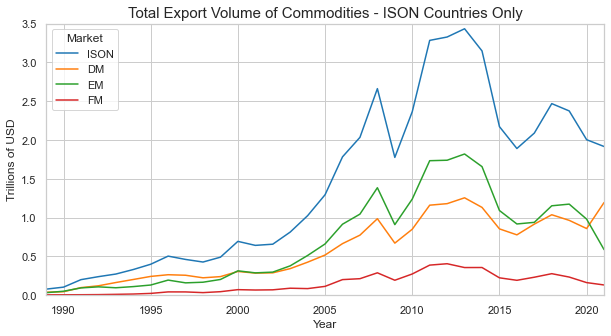

In [14]:
### STATS: Total Export Volume of Commodities - WORLD Partner

### Key numbers:
print('UN Comtrade Export: Total ISON Reporters number:', str(len(df_comm_world['Reporter'].unique())))
print('UN Comtrade Export: Total Commodity types number:', str(len(df_comm_world['Commodity_ID'].unique())))
### Total export volume calculation start:
dict_total_volume = {}
### ISON total volume:
ser_total_volume = df_comm_world.groupby('Date')['Value'].sum() / 1000000000000
dict_total_volume['ISON'] = ser_total_volume
df_comm_world_isoned = df_comm_world.join(ser_ison_status, on = 'Reporter')
### Region's total volume:
for iter_region in list_region:
    ser_iter_volume = df_comm_world_isoned[df_comm_world_isoned['Market'] == iter_region].groupby('Date')['Value'].sum() / 1000000000000
    dict_total_volume[iter_region] = ser_iter_volume
### Data consolidating:    
df_to_plot = pd.concat(dict_total_volume).reset_index()
df_to_plot.rename({'level_0': 'Market'}, axis = 1, inplace = True)
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot = df_to_plot.drop('Date', axis = 1)
### Total export volume plotting
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_total = sns.lineplot(data = df_to_plot, x = 'Year', y = 'Value', hue = 'Market')
ax_total.set_title('Total Export Volume of Commodities - ISON Countries Only', fontsize = 15)
ax_total.set(xlim = (1989, 2021), ylabel = 'Trillions of USD', ylim = (0.0, 3.5))
plt.show()

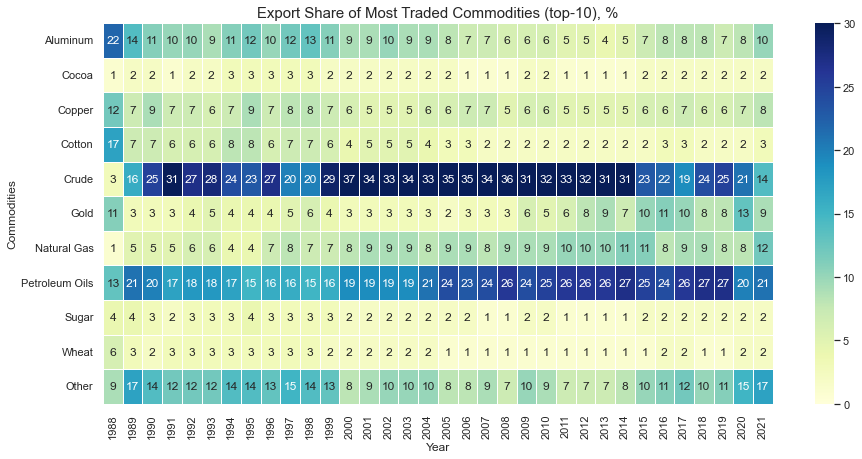

In [15]:
### STATS: WORDLEVEL EXPORT STRUCTURE BY COMMODITIES

gc.collect()
### Stats parameter - leaders to plot:
int_top = 10
### Commodity trade proprotion for each date:
ser_comm_value = df_comm_world.groupby(['Date', 'Commodity_Name'])['Value'].sum().dropna() / 1000000000
ser_total_value = df_comm_world.groupby(['Date'])['Value'].sum().dropna() / 1000000000
df_comm_part = (ser_comm_value / ser_total_value).round(2).reset_index()
df_comm_part['Year'] = df_comm_part['Date'].dt.year
ser_comm_part = df_comm_part.set_index(['Year', 'Commodity_Name']).drop('Date', axis = 1).squeeze()
### All-time commodity trade volume:
ser_comm_ave = ser_comm_part.groupby('Commodity_Name').sum().sort_values(ascending = False)
### Top commodities list:
idx_ave_top = ser_comm_ave[: int_top].index
### Other commodities list:
idx_ave_other = ser_comm_ave[int_top :].index
### Top commodities proportions extracting:
ser_comm_top = (ser_comm_part.loc[All, idx_ave_top] * 100)
#set index type from categorical (in the original datset) to string to add another caterogy 'Other'
ser_comm_top.index.set_levels(ser_comm_top.index.levels[1].astype('O'), level = 'Commodity_Name', inplace = True)
### Other commodities common proportion extracting:
ser_comm_other = (ser_comm_part.loc[All, idx_ave_other].groupby('Year').sum() * 100)
ser_comm_other = pd.concat({'Other': ser_comm_other}, names = ['Commodity_Name']).swaplevel()
### Data consolidating:
df_to_plot = pd.concat([ser_comm_top.sort_index().unstack('Year'), ser_comm_other.unstack('Year')], axis = 0)
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '.0f', center = 15, vmin = 0, vmax = 30)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Commodities')
ax_heatmap.set_title('Export Share of Most Traded Commodities (top-' + str(int_top) + '), %', fontsize = 15)
plt.yticks(rotation = 0)
plt.show()      

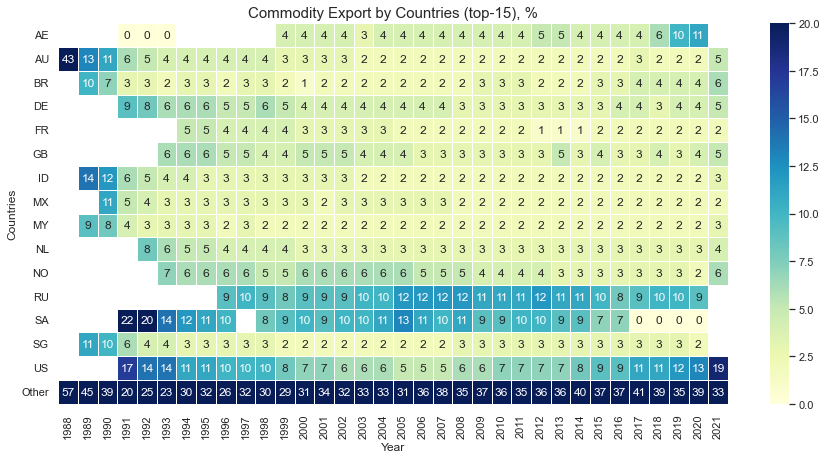

In [16]:
### STATS: Commodity Export by Countries - WORLD LEVEL

gc.collect()
### Stats parameter - leaders to plot:
int_top = 15
### Country trade proprotion for each date:
ser_country_value = df_comm_world.groupby(['Date', 'Reporter'])['Value'].sum().dropna() / 1000000000
ser_total_value = df_comm_world.groupby(['Date'])['Value'].sum().dropna() / 1000000000
df_country_part = (ser_country_value / ser_total_value).round(2).reset_index()
df_country_part['Year'] = df_country_part['Date'].dt.year
ser_country_part = df_country_part.set_index(['Year', 'Reporter']).drop('Date', axis = 1).squeeze()
### All-time country trade volume:
ser_country_ave = ser_country_part.groupby('Reporter').sum().sort_values(ascending = False)
### Top countries list:
idx_ave_top = ser_country_ave[: int_top].index
### Other countries list:
idx_ave_other = ser_country_ave[int_top :].index
### Top countries proportions extracting:
ser_country_top = (ser_country_part.loc[All, idx_ave_top] * 100)
ser_country_top.index.set_levels(ser_country_top.index.levels[1].astype('O'), level = 'Reporter', inplace = True) 
### Other countries proportions extracting:
ser_country_other = (ser_country_part.loc[All, idx_ave_other].groupby('Year').sum() * 100)
ser_country_other = pd.concat({'Other': ser_country_other}, names = ['Reporter']).swaplevel()
### Data consolidating:
df_to_plot = pd.concat([ser_country_top.unstack('Year').sort_index(), ser_country_other.unstack('Year')], axis = 0)
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '.0f', center = 10, vmin = 0, vmax = 20)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Commodity Export by Countries (top-' + str(int_top) + '), %', fontsize = 15)
plt.yticks(rotation = 0)
plt.show()      

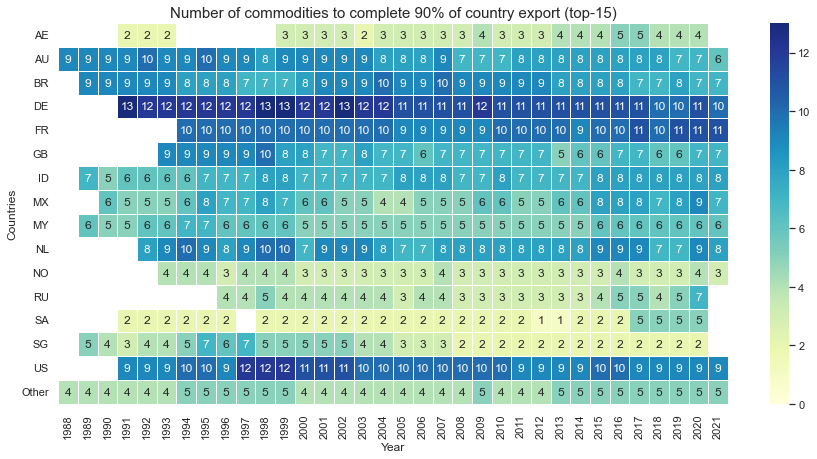

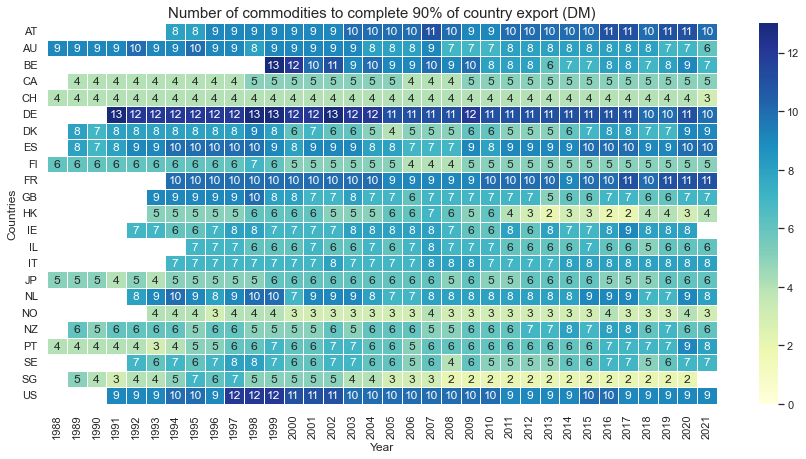

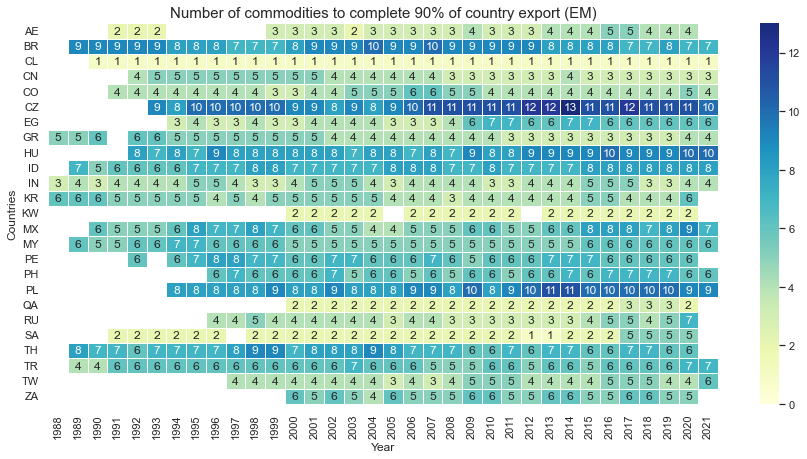

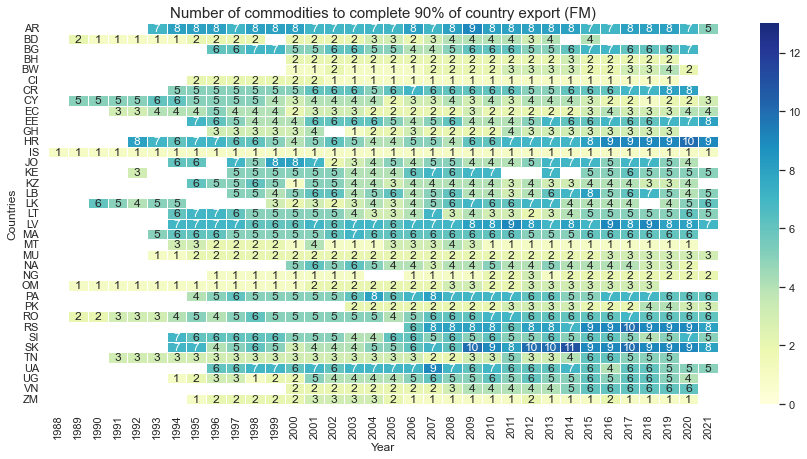

In [17]:
### STATS: NUMBER OF COMMODITIES TO COMPLETE TOP-% FOR COUNTRY
### Q: How many commodities does a country trade (limit to top 90% of export)? 

### parameter: export share
flo_perc = 0.90
### parameter: No of countries to plot
int_top = 15

gc.collect()
### Defining top-% commodities number calculation procedure:
def get_top_comm(df_group, flo_perc):
    df_group = df_group.sort_values('Value', ascending = False).reset_index()
    ser_cum_sum = df_group['Value'].cumsum() / df_group['Value'].sum()
    return len(ser_cum_sum[ser_cum_sum < flo_perc]) + 1

### Top-% commodities number calculation for each Date / Reporter pair:
ser_top_comm = df_comm_world.groupby(['Date', 'Reporter']).apply(get_top_comm, flo_perc).astype(int)
ser_top_comm.name = 'Number'
df_top_comm = ser_top_comm.to_frame().join(ser_ison_status, on = 'Reporter').reset_index()
### Trade leaders country list:
idx_ave_top = ser_country_ave[: int_top].index
### Other leaders country list:
idx_ave_other = ser_country_ave[int_top :].index    
### Leaders data extraction for leaders plot:
df_top_part = df_top_comm[df_top_comm['Reporter'].isin(idx_ave_top)].copy()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_top_comm[df_top_comm['Reporter'].isin(idx_ave_other)].groupby('Date')['Number'].mean().astype(int).reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part.drop('Date', axis = 1).squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plot plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         center = 7, vmin = 0, vmax = 13)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Number of commodities to complete ' + str(int(flo_perc * 100)) + '% of country export (top-' + str(int_top) + ')' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()
### Region's data plotting:
for iter_region in list_region:
    ### Data extraction:
    df_to_plot = df_top_comm.loc[df_top_comm['Market'] == iter_region].copy()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             center = 7, vmin = 0, vmax = 13)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title('Number of commodities to complete ' + str(int(flo_perc * 100)) + '% of country export (' + iter_region + ')' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()

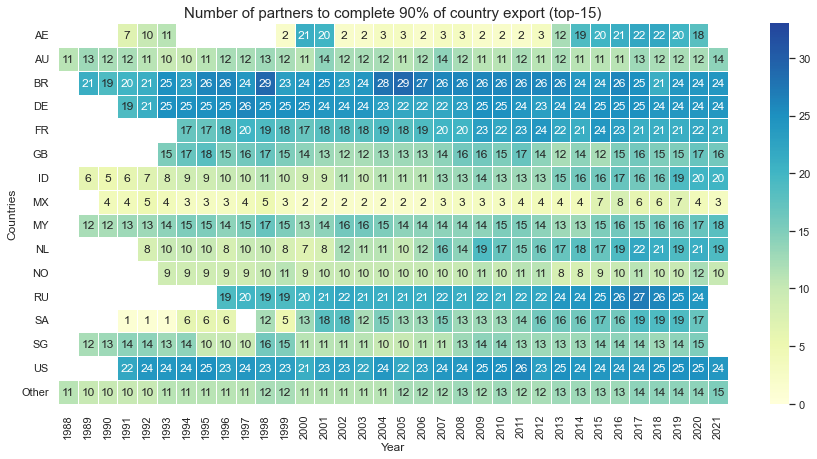

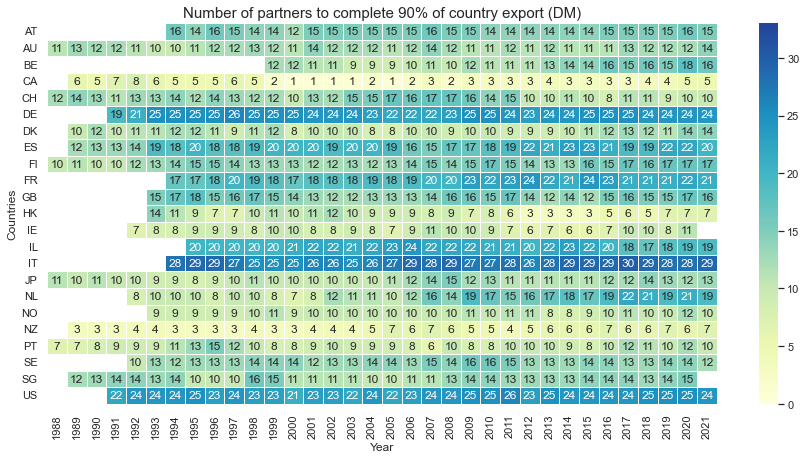

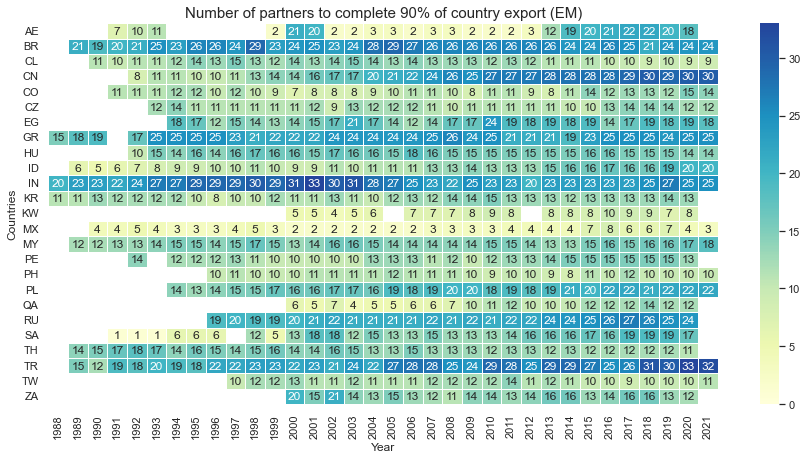

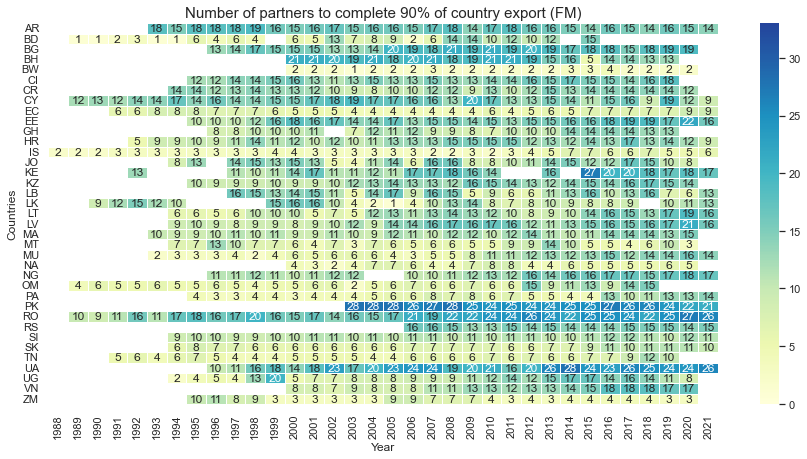

In [19]:
### STATS: NUMBER OF PARTNERS TO COMPLETE TOP-% FOR COUNTRY
### Q: How many partners does a country trade with (limit to top 90% of export)? 

### parameter: export share
flo_perc = 0.90
### parameter: No of countries to plot
int_top = 15

gc.collect()
### Defining top-% partners number calculation procedure:
def get_top_partners(df_group, flo_perc):
    ser_by_partner = df_group.groupby(['Date', 'Partner'])['Value'].sum().dropna().sort_values(ascending = False)
    ser_cum_sum = ser_by_partner.cumsum() / ser_by_partner.sum()
    return len(ser_cum_sum[ser_cum_sum < flo_perc]) + 1
### Top-% partners number calculation for each Date / Reporter pair:
ser_top_partners = df_comm_full.groupby(['Date', 'Reporter']).apply(get_top_partners, flo_perc).astype(int)
ser_top_partners.name = 'Number'
df_top_partners = ser_top_partners.to_frame().join(ser_ison_status, on = 'Reporter').reset_index()
### Trade leaders countries list:
idx_ave_top = ser_country_ave[: int_top].index
### Other leaders countries list:
idx_ave_other = ser_country_ave[int_top :].index    
### Leaders data extraction for leaders plot:
df_top_part = df_top_partners[df_top_partners['Reporter'].isin(idx_ave_top)].copy()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_top_partners[df_top_partners['Reporter'].isin(idx_ave_other)].groupby('Date')['Number'].mean().astype(int).reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part.drop('Date', axis = 1).squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plot plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         center = 20, vmin = 0, vmax = 33)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Number of partners to complete ' + str(int(flo_perc * 100)) + '% of country export (top-' + str(int_top) + ')' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()
### Region's data plotting:
for iter_region in list_region:
    ### Data extraction:    
    df_to_plot = df_top_partners.loc[df_top_partners['Market'] == iter_region].copy()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             center = 20, vmin = 0, vmax = 33)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title('Number of partners to complete ' + str(int(flo_perc * 100)) + '% of country export (' + iter_region + ')' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

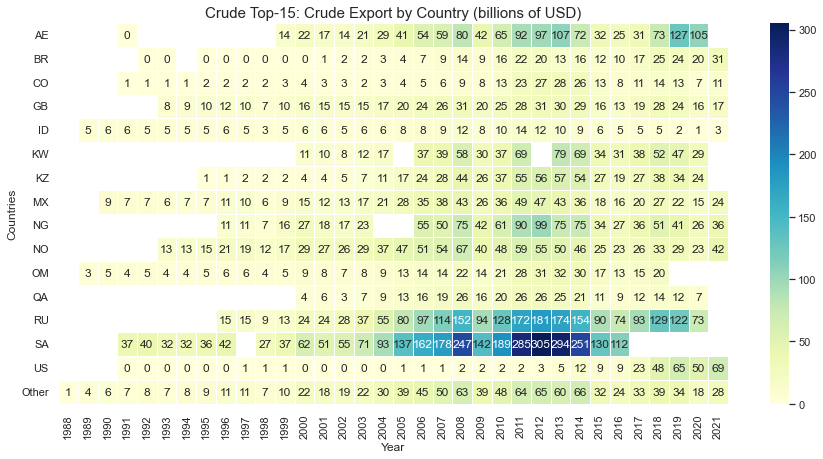

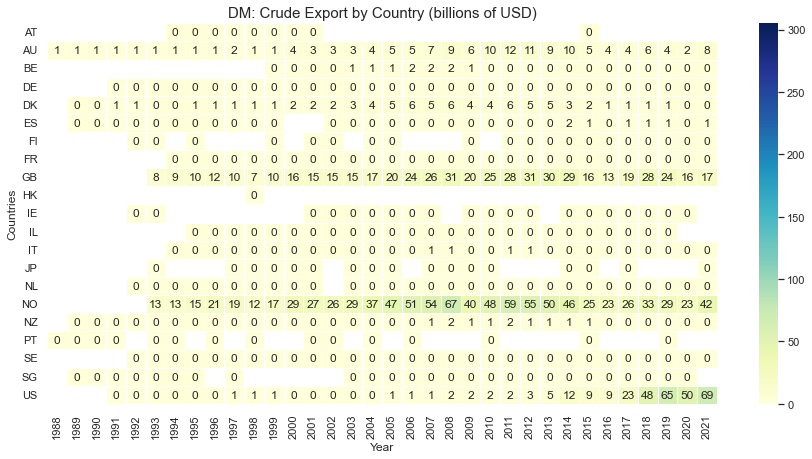

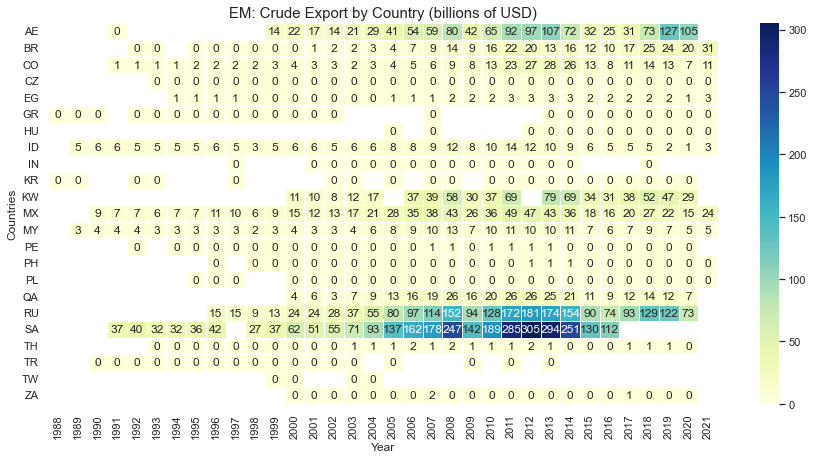

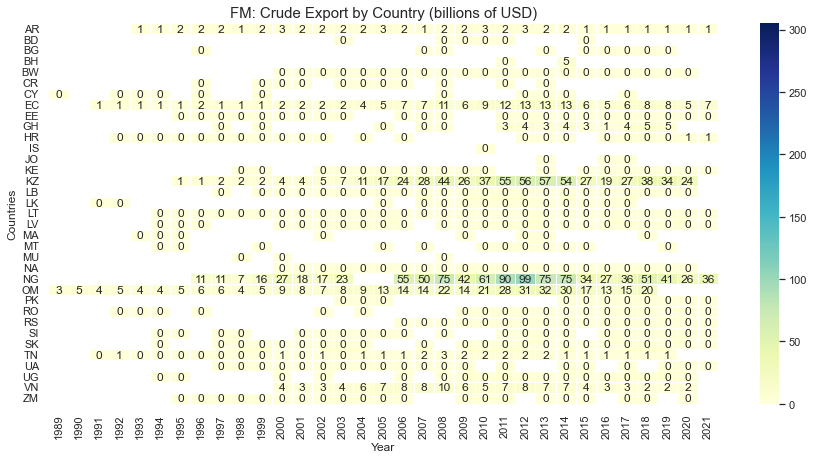

In [20]:
### STATS: Countries Exporters of a certain commodity
### Notice that SA stopped reporting 'Crude' but keeps reporting total Export. Potential solution to fill Crude volume using 2016 export shares.  

### parameter: commodity to plot
str_comm = 'Crude'
### parameter: leaders to plot
int_top = 15

### ISON status adding:
df_comm_distr = df_comm_world[df_comm_world['Commodity_Name'] == str_comm].join(ser_ison_status, on = 'Reporter')
ser_slice_ave = df_comm_distr.groupby('Reporter')['Value'].sum().sort_values(ascending = False)
### Maximum value calculation:
int_max = int(df_comm_distr['Value'].max() / 1000000000)
### Trade leaders countries list:
idx_ave_top = ser_slice_ave[: int_top].index
### Other leaders countries list:
idx_ave_other = ser_slice_ave[int_top :].index    
### Leaders data extraction for leaders plot:
df_top_part = df_comm_distr[df_comm_distr['Reporter'].isin(idx_ave_top)].copy()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part[['Year', 'Reporter', 'Value']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index() / 1000000000
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_comm_distr[df_comm_distr['Reporter'].isin(idx_ave_other)].groupby('Date')['Value'].sum().astype('int64').reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part['Value'].unstack('Year') / 1000000000
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plot plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = int_max // 2, vmin = 0, vmax = int_max)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title(str_comm + ' Top-' + str(int_top) + ': ' + str_comm + ' Export by Country (billions of USD)' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()
### Region's data plotting:
for iter_region in list_region:
    ### Data extraction:
    df_to_plot = df_comm_distr.loc[df_comm_distr['Market'] == iter_region].copy()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot[['Year', 'Reporter', 'Value']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index() / 1000000000
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             fmt = '0.0f', center = int_max // 2, vmin = 0, vmax = int_max)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title(iter_region + ': ' + str_comm + ' Export by Country (billions of USD)' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

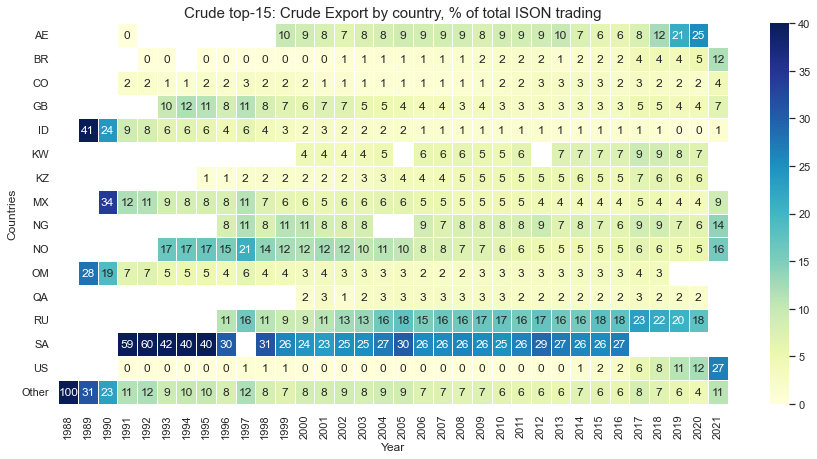

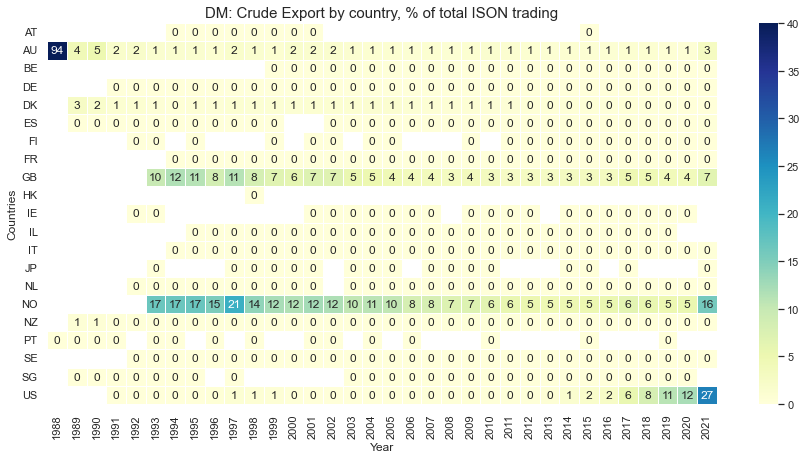

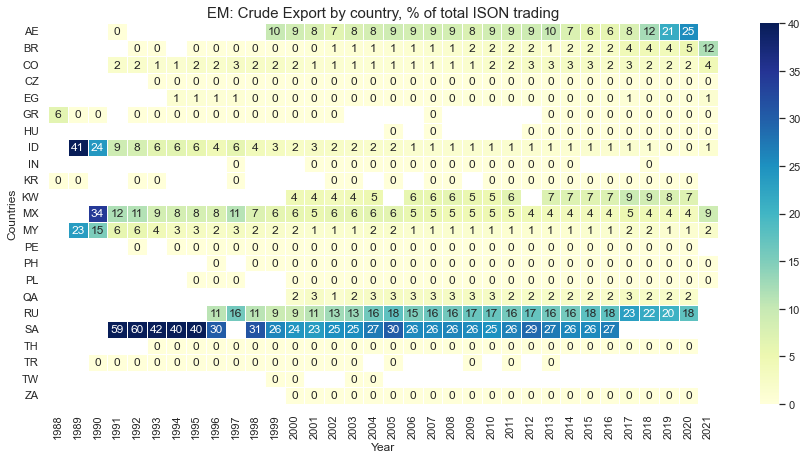

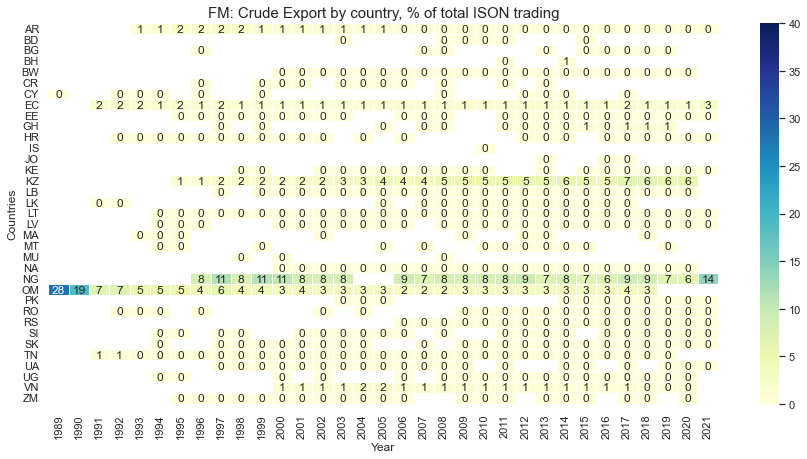

In [21]:
### NEW!!! ### STATS: COMMODITY EXPORT DISTRIBUTION, PROPORTION

### Stats parameter - commodity to plot:
str_comm = 'Crude'
### Stats parameter - leaders to plot:
int_top = 15
### ISON status adding:
df_comm_distr = df_comm_world[df_comm_world['Commodity_Name'] == str_comm].join(ser_ison_status, on = 'Reporter')
df_comm_distr['Proportion'] = df_comm_distr.groupby('Date')['Value'].apply(lambda ser_group: ser_group * 100 / ser_group.sum())
ser_slice_ave = df_comm_distr.groupby('Reporter')['Value'].sum().sort_values(ascending = False)
### Trade leaders countries list:
idx_ave_top = ser_slice_ave[: int_top].index
### Other leaders countries list:
idx_ave_other = ser_slice_ave[int_top :].index    
### Leaders data extraction for leaders plot:
df_top_part = df_comm_distr[df_comm_distr['Reporter'].isin(idx_ave_top)].copy()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part[['Year', 'Reporter', 'Proportion']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_comm_distr[df_comm_distr['Reporter'].isin(idx_ave_other)].groupby('Date')['Proportion'].sum().reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part['Proportion'].unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plot plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = 20, vmin = 0, vmax = 40)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title(str_comm + ' top-' + str(int_top) + ': ' + str_comm + ' Export by country, % of total ISON trading' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()
### Region's data plotting:
for iter_region in list_region:
    ### Data extraction:
    df_to_plot = df_comm_distr.loc[df_comm_distr['Market'] == iter_region].copy()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot[['Year', 'Reporter', 'Proportion']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             fmt = '0.0f', center = 20, vmin = 0, vmax = 40)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title(iter_region + ': ' + str_comm + ' Export by country, % of total ISON trading' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

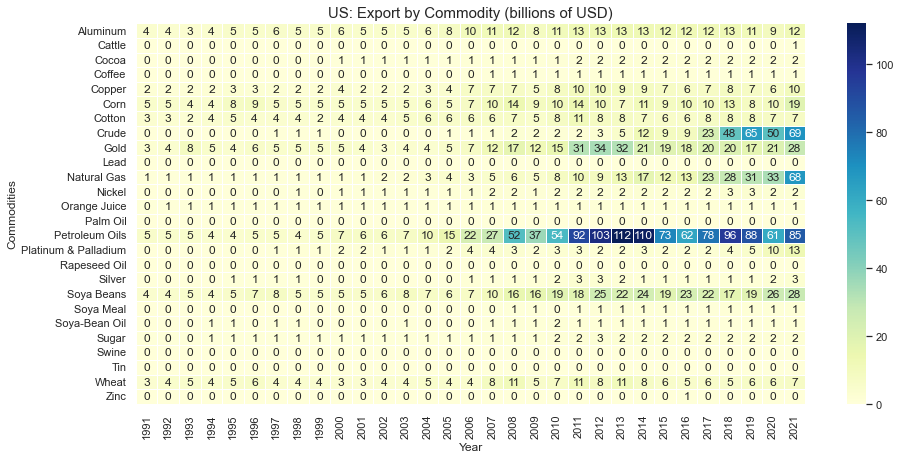

In [43]:
### STATS: COUNTRY EXPORT DISTRIBUTION

### Stats parameter - country to slice:
str_country = 'US'
### Country slicing:
df_comm_distr = df_comm_world[df_comm_world['Reporter'] == str_country]
int_max = int(df_comm_distr['Value'].max() / 1000000000)
### Data extraction:
df_to_plot = df_comm_distr.copy()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot = df_to_plot[['Year', 'Commodity_Name', 'Value']].set_index(['Commodity_Name', 'Year']).squeeze().unstack('Year').sort_index() / 1000000000
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = int_max // 2, vmin = 0, vmax = int_max)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Commodities')
ax_heatmap.set_title(str_country + ': Export by Commodity (billions of USD)' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()  

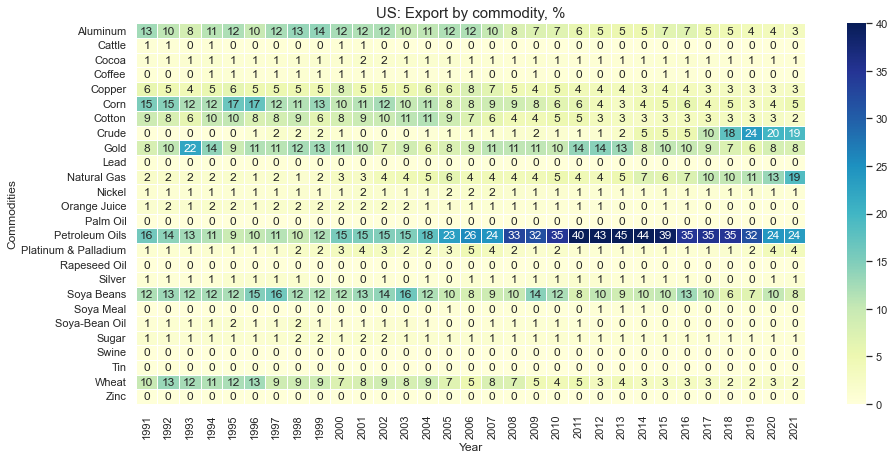

In [22]:
### NEW !!! ### STATS: COUNTRY EXPORT DISTRIBUTION, %

### Stats parameter - country to slice:
str_country = 'US'
### Country slicing:
df_comm_distr = df_comm_world[df_comm_world['Reporter'] == str_country].copy()
df_comm_distr['Proportion'] = df_comm_distr.groupby('Date')['Value'].apply(lambda ser_group: ser_group * 100 / ser_group.sum())
### Data extraction:
df_to_plot = df_comm_distr.copy()
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot = df_to_plot[['Year', 'Commodity_Name', 'Proportion']].set_index(['Commodity_Name', 'Year']).squeeze().unstack('Year').sort_index()
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = 20, vmin = 0, vmax = 40)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Commodities')
ax_heatmap.set_title(str_country + ': Export by commodity, %' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()  

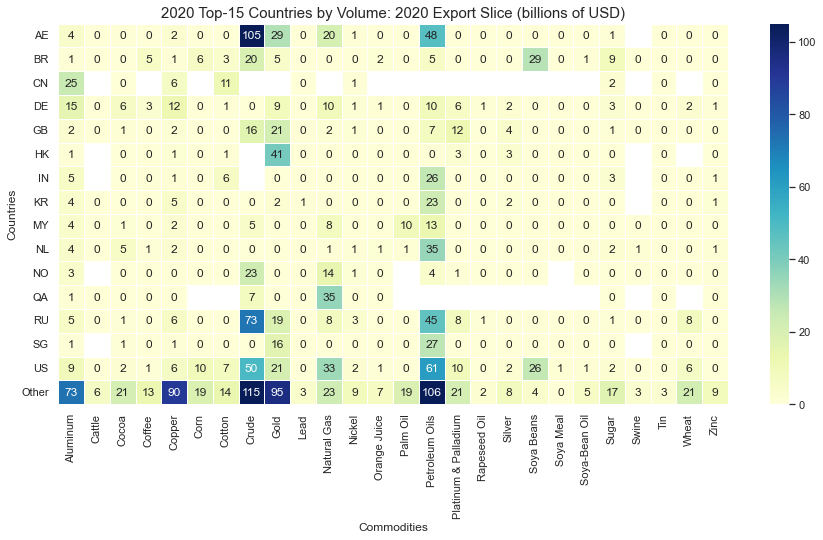

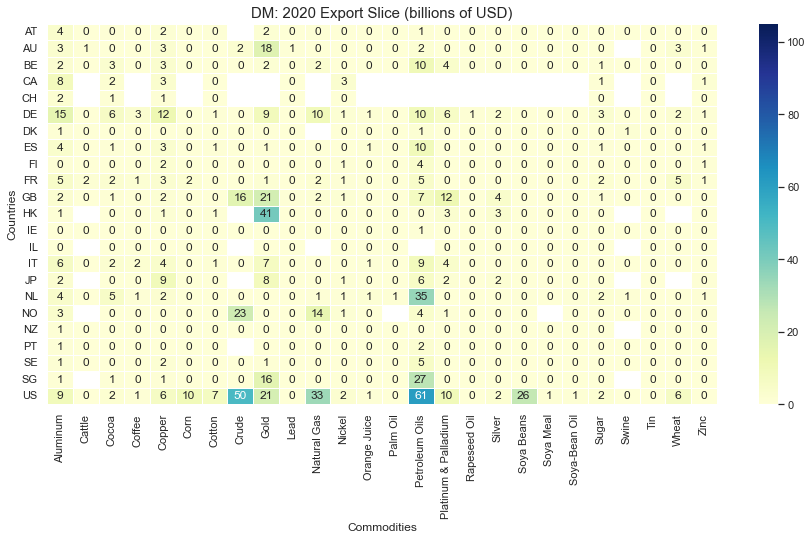

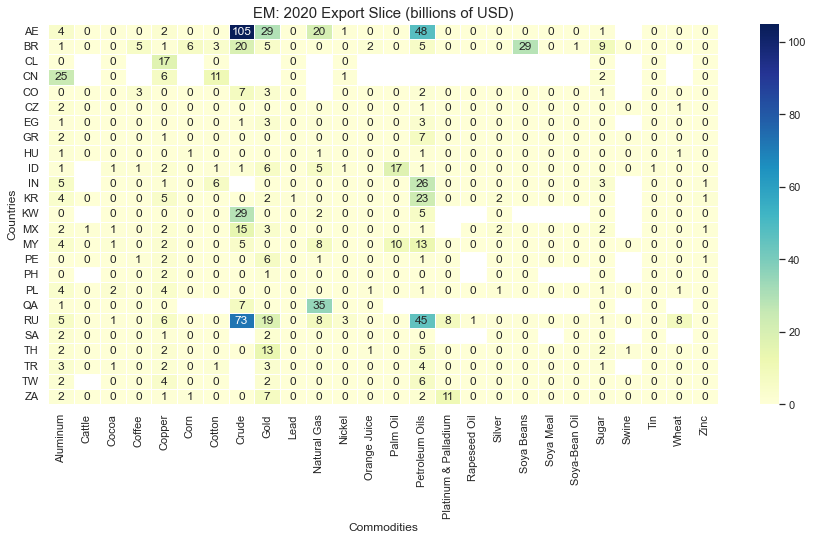

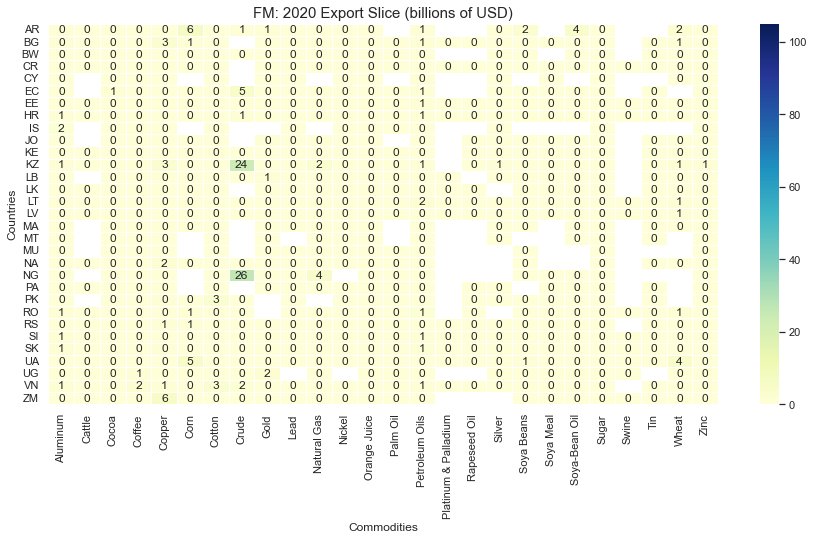

In [23]:
### STATS: YEAR SLICE: MEASURED BY USD

gc.collect()
### Stats parameter - year to slice:
int_year = 2020
### Stats parameter - leaders to plot:
int_top = 15
### Year slicing:
df_comm_distr = df_comm_world[df_comm_world['Date'].dt.year == int_year].join(ser_ison_status, on = 'Reporter')
ser_slice_ave = df_comm_distr.groupby('Reporter')['Value'].sum().sort_values(ascending = False)
### Maximum value defining:
int_max = int(df_comm_distr['Value'].max() / 1000000000)
### Trade leaders countries list:
idx_ave_top = ser_slice_ave[: int_top].index
### Other leaders countries list:
idx_ave_other = ser_slice_ave[int_top :].index    
### Leaders data extraction for leaders plot:
df_top_part = df_comm_distr.loc[df_comm_distr['Reporter'].isin(idx_ave_top), ['Reporter', 'Commodity_Name', 'Value']].copy()
df_top_part = df_top_part.set_index(['Commodity_Name', 'Reporter']).squeeze().sort_index().unstack('Commodity_Name') / 1000000000
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_comm_distr[df_comm_distr['Reporter'].isin(idx_ave_other)].groupby('Commodity_Name')['Value'].sum().astype('int64').reset_index()
df_other_part = pd.concat({'Other': df_other_part.set_index('Commodity_Name')}, names = ['Reporter'])
df_other_part = df_other_part.squeeze().unstack('Commodity_Name')[df_top_part.columns] / 1000000000
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = int_max // 2, vmin = 0, vmax = int_max)
ax_heatmap.set(xlabel = 'Commodities', ylabel = 'Countries')
ax_heatmap.set_title(str(int_year) + ' Top-' + str(int_top) + ' Countries by Volume: ' + str(int_year) + ' Export Slice (billions of USD)' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()  
### Region's data plotting:
for iter_region in list_region:
    ### Data extraction:    
    df_to_plot = df_comm_distr.loc[df_comm_distr['Market'] == iter_region, ['Reporter', 'Commodity_Name', 'Value']].copy()
    df_to_plot = df_to_plot.set_index(['Commodity_Name', 'Reporter']).squeeze().sort_index().unstack('Commodity_Name') / 1000000000
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             fmt = '0.0f', center = int_max // 2, vmin = 0, vmax = int_max)
    ax_heatmap.set(xlabel = 'Commodities', ylabel = 'Countries')
    ax_heatmap.set_title(iter_region + ': ' + str(int_year) + ' Export Slice (billions of USD)' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

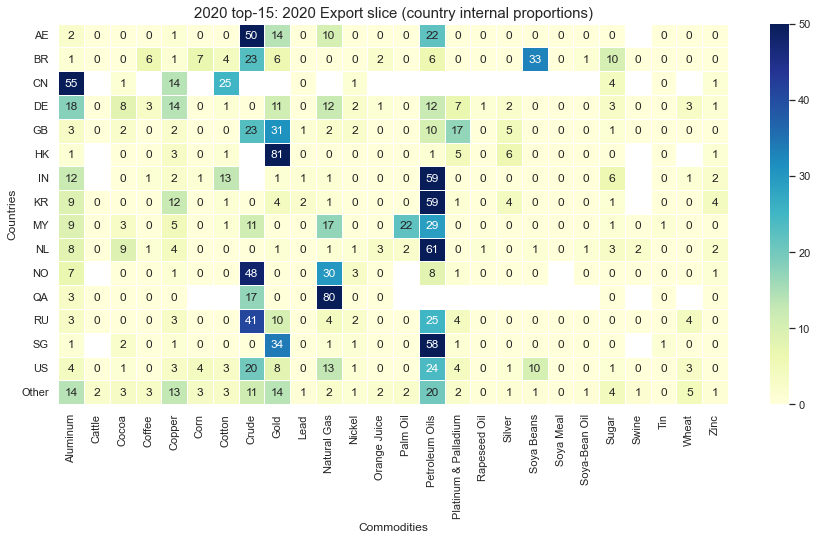

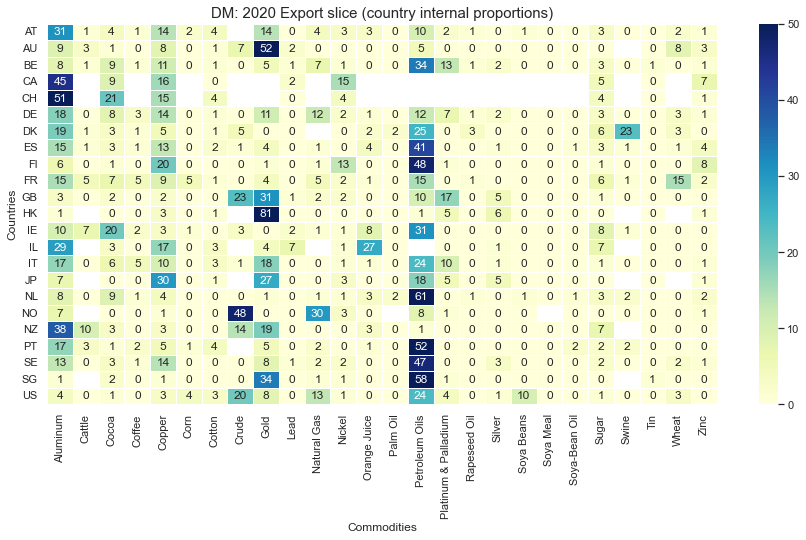

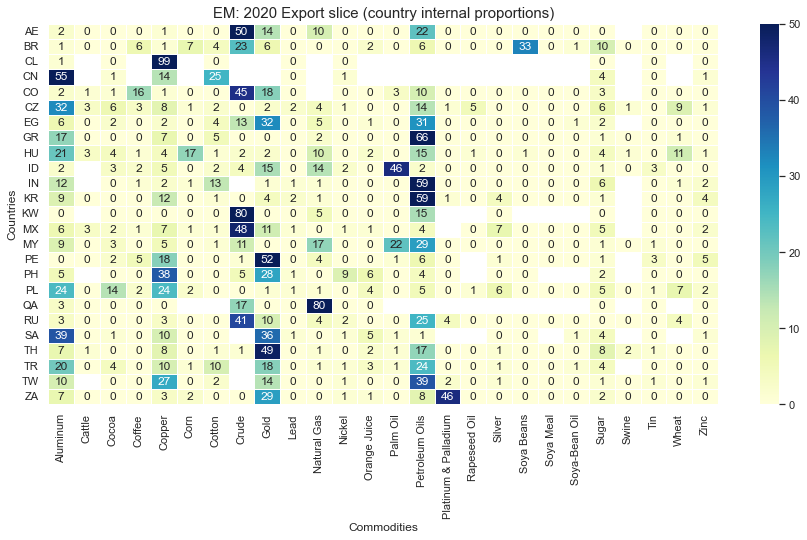

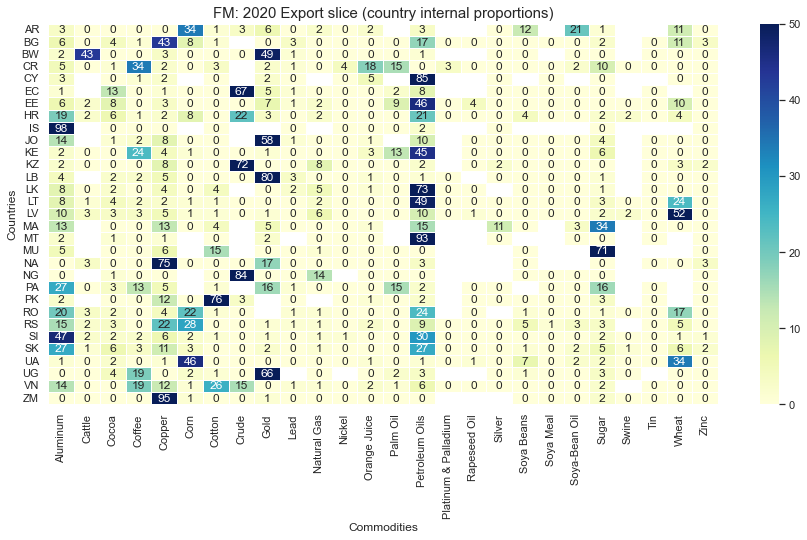

In [24]:
### STATS: YEAR SLICE: MEASURED BY Wintin COUNTRY %

gc.collect()
### parameter: year to slice
int_year = 2020
### parameter: countries to plot:
int_top = 15
### Year slicing:
df_comm_distr = df_comm_world[df_comm_world['Date'].dt.year == int_year].join(ser_ison_status, on = 'Reporter')
df_comm_distr['Proportion'] = df_comm_distr.groupby(['Reporter'])['Value'].apply(lambda ser_group: ser_group * 100 / ser_group.sum()).round(0)
ser_slice_ave = df_comm_distr.groupby('Reporter')['Value'].sum().sort_values(ascending = False)
### Trade leaders countries list:
idx_ave_top = ser_slice_ave[: int_top].index
### Other leaders countries list:
idx_ave_other = ser_slice_ave[int_top :].index    
### Leaders data extraction for leaders plot:
df_top_part = df_comm_distr.loc[df_comm_distr['Reporter'].isin(idx_ave_top), ['Reporter', 'Commodity_Name', 'Proportion']].copy()
df_top_part = df_top_part.set_index(['Commodity_Name', 'Reporter']).squeeze().sort_index().unstack('Commodity_Name')
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_comm_distr[df_comm_distr['Reporter'].isin(idx_ave_other)].groupby('Commodity_Name')['Proportion'].mean().reset_index()
df_other_part = pd.concat({'Other': df_other_part.set_index('Commodity_Name')}, names = ['Reporter'])
df_other_part = df_other_part.squeeze().unstack('Commodity_Name')[df_top_part.columns]
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = 25, vmin = 0, vmax = 50)
ax_heatmap.set(xlabel = 'Commodities', ylabel = 'Countries')
ax_heatmap.set_title(str(int_year) + ' top-' + str(int_top) + ': ' + str(int_year) + ' Export slice (country internal proportions)' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()  
### Region's data plotting:
for iter_region in list_region:
    ### Data extraction: 
    df_to_plot = df_comm_distr.loc[df_comm_distr['Market'] == iter_region, ['Reporter', 'Commodity_Name', 'Proportion']].copy()
    df_to_plot = df_to_plot.set_index(['Commodity_Name', 'Reporter']).squeeze().sort_index().unstack('Commodity_Name')
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             fmt = '0.0f', center = 25, vmin = 0, vmax = 50)
    ax_heatmap.set(xlabel = 'Commodities', ylabel = 'Countries')
    ax_heatmap.set_title(iter_region + ': ' + str(int_year) + ' Export slice (country internal proportions)' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

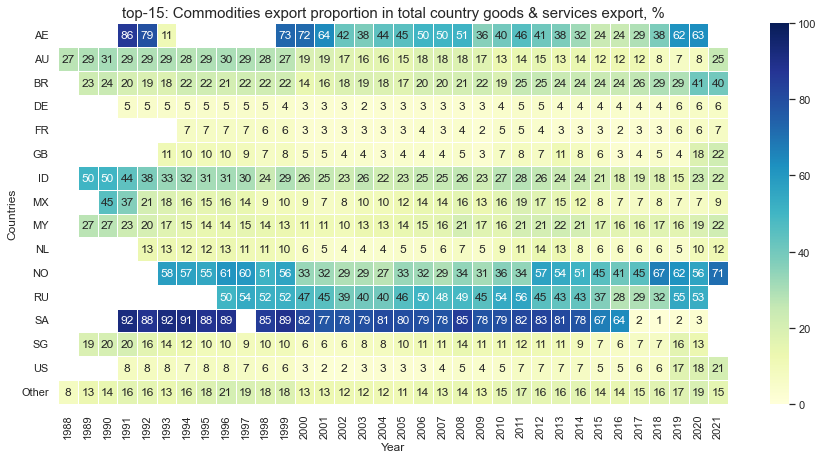

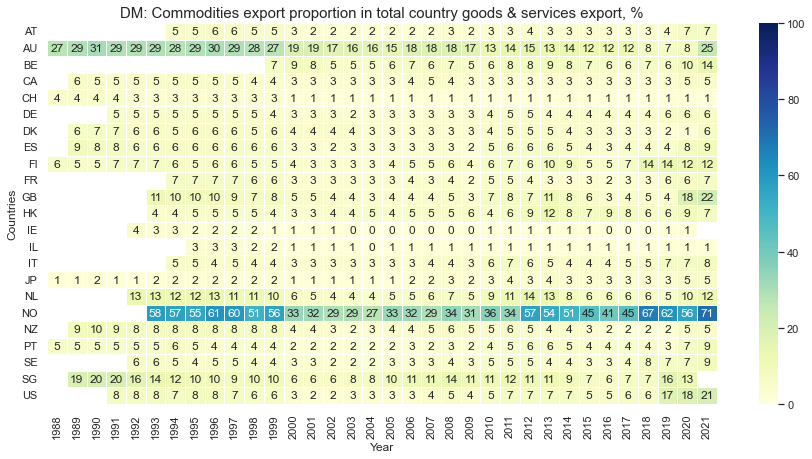

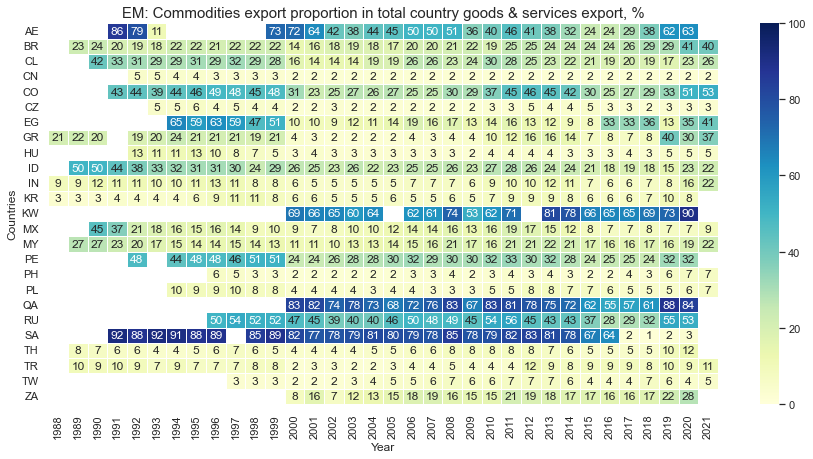

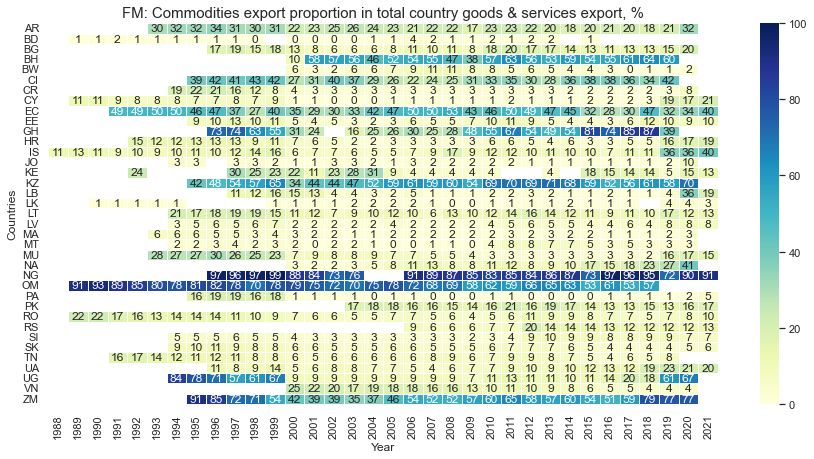

In [46]:
### 20220629 ### STATS: COMMODITIES EXPORT PROPORTION IN OVERALL COUNTRY GOODS & SERVICES EXPORT

gc.collect()
### Stats parameter - leaders to plot:
int_top = 15
### Global export data loading:
df_global_world = pd.read_hdf(path_or_buf = str_path_global, key = str_key_unc, where = 'Flow = Export').droplevel('Flow')
### Proportion calculating:
ser_comm_proportion = (df_comm_world.groupby(['Date', 'Reporter'])['Value'].sum().dropna() * 100 / df_global_world).round(0)
df_comm_proportion = ser_comm_proportion.to_frame().join(ser_ison_status, on = 'Reporter').reset_index()
### Trade leaders countries list:
idx_ave_top = ser_country_ave[: int_top].index
### Other leaders countries list:
idx_ave_other = ser_country_ave[int_top :].index    
### Leaders data extraction for leaders plot:
df_top_part = df_comm_proportion.loc[df_comm_proportion['Reporter'].isin(idx_ave_top)].copy()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part[['Year', 'Reporter', 'Value']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_comm_proportion[df_comm_proportion['Reporter'].isin(idx_ave_other)].groupby('Date')['Value'].mean().reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part['Value'].squeeze().unstack('Year')
### Region's average values:
list_regions_ave = []
for iter_region in list_region:
    df_iter_part = df_comm_proportion[df_comm_proportion['Market'] == iter_region].groupby('Date')['Value'].mean().reset_index()
    df_iter_part['Year'] = df_iter_part['Date'].dt.year
    df_iter_part = pd.concat({iter_region: df_iter_part.set_index('Year')}, names = ['Reporter'])
    df_iter_part = df_iter_part['Value'].squeeze().unstack('Year')
    list_regions_ave.append(df_iter_part)
df_regions = pd.concat(list_regions_ave, axis = 0)
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part, df_regions], axis = 0)
### Leaders plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = 50, vmin = 0, vmax = 100)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('top-' + str(int_top) + ': ' + 'Commodities export proportion in total country goods & services export, %' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()  
### Region's data plotting:
for iter_region in list_region:
    ### Data extraction:    
    df_to_plot = df_comm_proportion.loc[df_comm_proportion['Market'] == iter_region].copy()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot[['Year', 'Reporter', 'Value']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             fmt = '0.0f', center = 50, vmin = 0, vmax = 100)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title(iter_region + ': ' + ' Proportion of commodities export in total country goods & services export, %' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

ISON sum > World sum:


Date        Reporter  Commodity_Name
2019-12-31  NA        Lead             -4.599638
Name: Value, dtype: float64

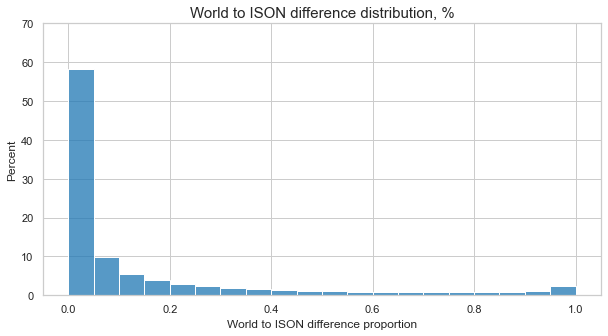

In [25]:
### STATS: DIFFERENCE BETWEEN WORLD AND ISON EXPORT: DATE / REPORTER / COMMODITY LEVEL DISTRIBUTION
### comparing the sum of bi-lateral trade with reported total with reported all world trade
gc.collect
### Stats parameter:
flo_error = -0.01
### ISON total trade:
ser_comm_ison = df_comm_full.groupby(['Date', 'Reporter', 'Commodity_Name'])['Value'].sum()#.dropna()
### Difference caclulating:
ser_comm_world = df_comm_world.set_index(['Date', 'Reporter', 'Commodity_Name'])['Value']
ser_comm_diff = ((ser_comm_world - ser_comm_ison) / ser_comm_world).dropna()
print('ISON sum > World sum:')
display(ser_comm_diff[ser_comm_diff < flo_error])
### Turning negative proportions to zeroes:
ser_comm_diff.clip(lower = 0.0, inplace = True)
### Differences plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_hist = sns.histplot(data = ser_comm_diff.reset_index(), x = 'Value', bins = 20, binrange = (0.0, 1.0), stat = 'percent')
ax_hist.set(xlabel = 'World to ISON difference proportion', ylim = (0, 70))
ax_hist.set_title('World to ISON difference distribution, %', fontsize = 15)
plt.yticks(rotation = 0)
plt.show()
#display(df_comm_full[(df_comm_full['Reporter'] == 'CH') & (df_comm_full['Date'] == '2013-12-31')].groupby('Commodity_Name')['Value'].sum())
#display(df_comm_world[(df_comm_world['Reporter'] == 'CH') & (df_comm_world['Date'] == '2013-12-31')])

In [26]:
ser_comm_diff.sort_values(ascending = False)

Date        Reporter  Commodity_Name
2003-12-31  OM        Crude             1.000000
2006-12-29  KW        Natural Gas       1.000000
2016-12-30  KW        Natural Gas       1.000000
2013-12-31  OM        Crude             1.000000
2014-12-31  OM        Crude             0.999999
                                          ...   
2013-12-31  FI        Corn              0.000000
1998-12-31  IS        Zinc              0.000000
2013-12-31  FI        Crude             0.000000
1998-12-31  IS        Lead              0.000000
2012-12-31  PK        Zinc              0.000000
Name: Value, Length: 50682, dtype: float64

ISON sum > World sum:


Series([], Name: Not_Covered, dtype: float64)

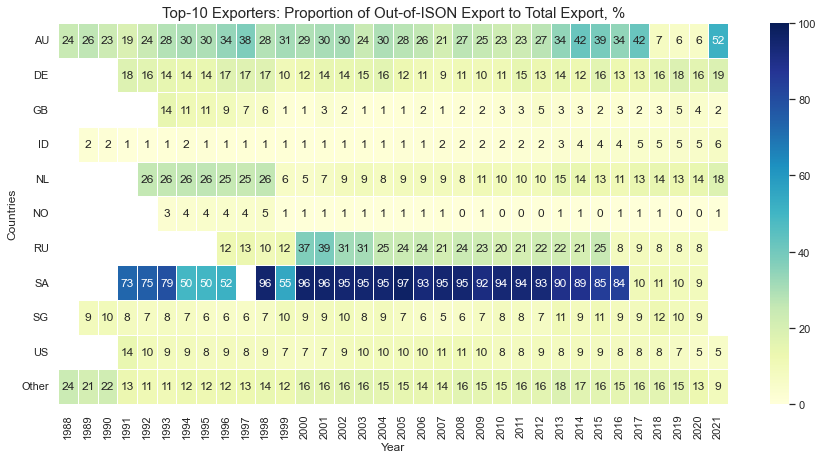

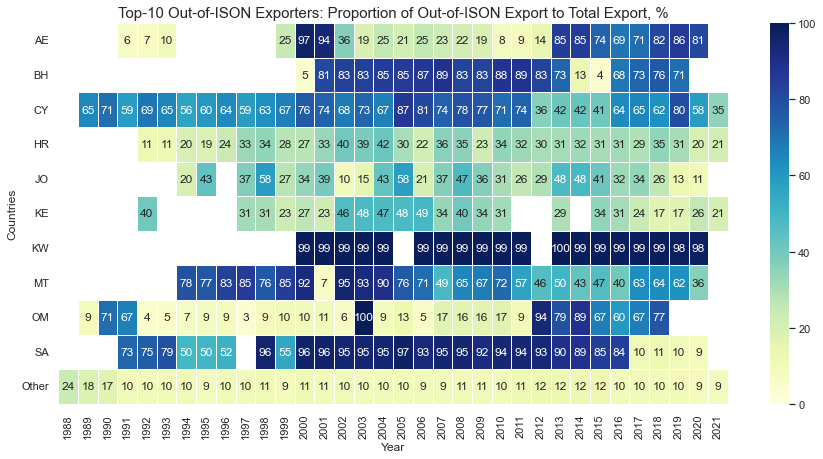

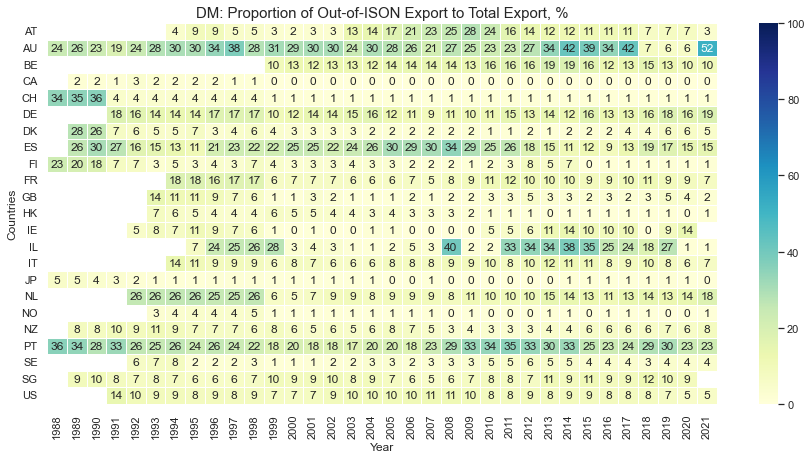

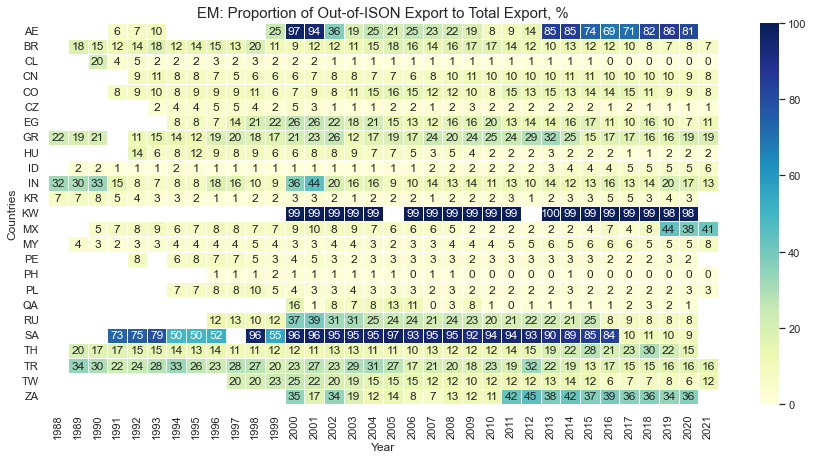

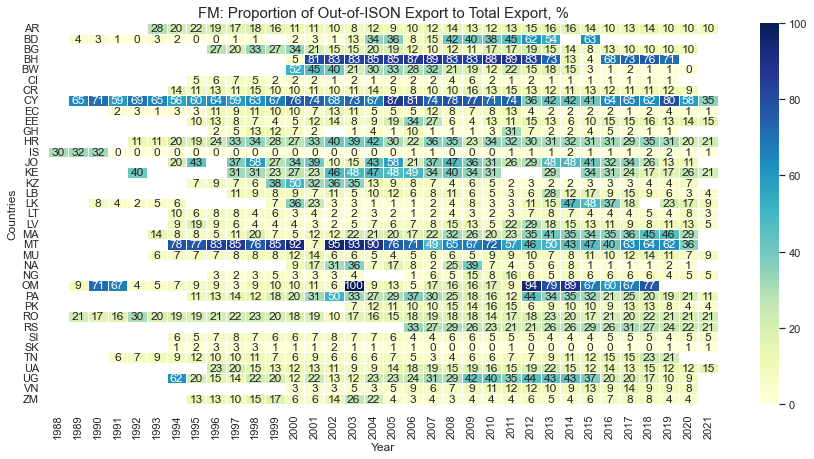

In [29]:
### STATS: DIFFERENCE BETWEEN WORLD AND ISON EXPORT: DATE / REPORTER

gc.collect
### Stats parameter:
flo_error = -0.01
### Top number:
int_top = 10
### ISON total trade:
ser_comm_ison = df_comm_full.groupby(['Date', 'Reporter', 'Commodity_Name'])['Value'].sum()#.dropna()
ser_comm_ison.name = 'Total_ISON'
### Difference caclulating:
ser_comm_world = df_comm_world.set_index(['Date', 'Reporter', 'Commodity_Name'])['Value']
ser_comm_world.name = 'World'
df_comm_sum = pd.concat([ser_comm_world, ser_comm_ison], axis = 1).dropna() / 1000000000
df_comm_sum = df_comm_sum.groupby(['Date', 'Reporter']).sum()
ser_comm_diff = (1 - df_comm_sum['Total_ISON'] / df_comm_sum['World']) * 100
ser_comm_diff.name = 'Not_Covered'
print('ISON sum > World sum:')
display(ser_comm_diff[ser_comm_diff < flo_error])
ser_comm_ave = ser_comm_diff.groupby('Reporter').mean().sort_values(ascending = False)
### Trade leaders countries list:
idx_ave_top = ser_country_ave[: int_top].index
### Other countries list:
idx_ave_other = ser_country_ave[int_top :].index  
### Leaders data extraction for leaders plot:
df_top_part = ser_comm_diff.loc[All, idx_ave_top].reset_index()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part[['Year', 'Reporter', 'Not_Covered']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = ser_comm_diff.loc[All, idx_ave_other].reset_index().groupby('Date')['Not_Covered'].mean().reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part['Not_Covered'].squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = 50, vmin = 0, vmax = 100)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Top-' + str(int_top) + ' Exporters: ' + 'Proportion of Out-of-ISON Export to Total Export, %' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()  
### Externat trade countries list:
idx_ave_top = ser_comm_ave[: int_top].index
### Other countries list:
idx_ave_other = ser_comm_ave[int_top :].index  
### Leaders data extraction for leaders plot:
df_top_part = ser_comm_diff.loc[All, idx_ave_top].reset_index()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part[['Year', 'Reporter', 'Not_Covered']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = ser_comm_diff.loc[All, idx_ave_other].reset_index().groupby('Date')['Not_Covered'].mean().reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part['Not_Covered'].squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = 50, vmin = 0, vmax = 100)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Top-' + str(int_top) + ' Out-of-ISON Exporters: ' + 'Proportion of Out-of-ISON Export to Total Export, %' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()  
### Region's data plotting:
df_comm_diff = ser_comm_diff.to_frame().join(ser_ison_status, on = 'Reporter')
for iter_region in list_region:
    ### Data extraction:    
    df_to_plot = df_comm_diff.loc[df_comm_diff['Market'] == iter_region].copy().reset_index()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot[['Year', 'Reporter', 'Not_Covered']].set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             fmt = '0.0f', center = 50, vmin = 0, vmax = 100)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title(iter_region + ': ' + 'Proportion of Out-of-ISON Export to Total Export, %' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

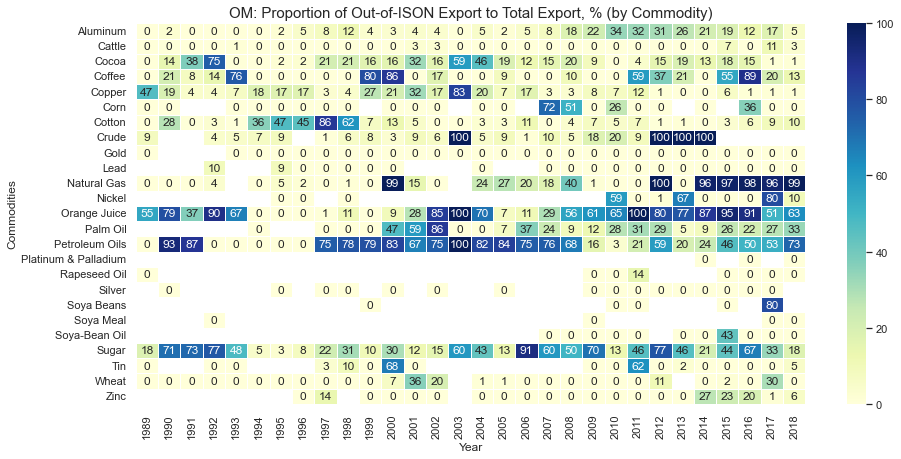

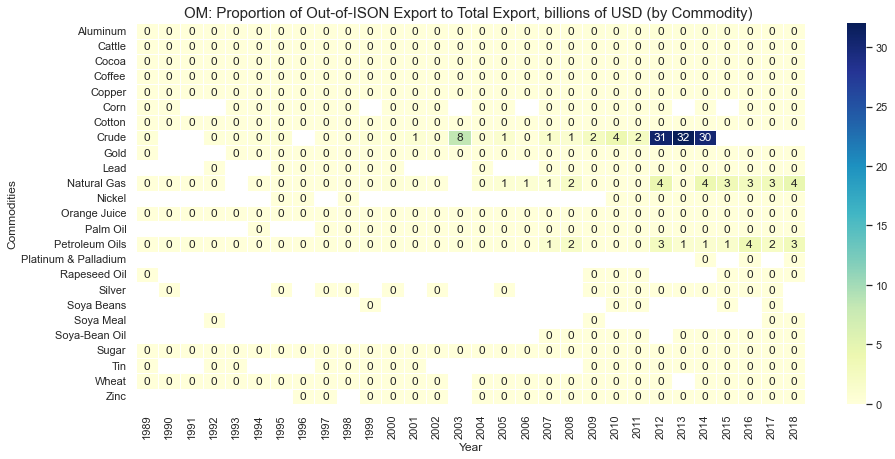

In [37]:
### STATS: DIFFERENCE BETWEEN WORLD AND ISON EXPORT: COUNTRY DETALIZATION, % NOT COVERED

### Country slice
str_country = 'OM' #'KW'
### Dates and commodities full lists:
idx_dates = sorted(df_comm_full['Date'].unique())
idx_comm = sorted(df_comm_full['Commodity_Name'].unique())
### ISON total trade:
ser_comm_ison = df_comm_full.groupby(['Date', 'Reporter', 'Commodity_Name'])['Value'].sum()#.dropna()
ser_comm_ison.name = 'Total_ISON'
### Difference caclulating:
ser_comm_world = df_comm_world.set_index(['Date', 'Reporter', 'Commodity_Name'])['Value']
ser_comm_world.name = 'World'
df_comm_compare = pd.concat([ser_comm_world, ser_comm_ison], axis = 1).dropna() / 1000000000
df_comm_compare['Not_covered'] = (1 - df_comm_compare['Total_ISON'] / df_comm_compare['World']).clip(lower = 0.0)
idx_full = pd.MultiIndex.from_product([idx_dates, idx_comm], names = ['Date', 'Commodity_Name'])
df_comm_compare = df_comm_compare['Not_covered'].unstack('Reporter').reindex(idx_full).stack('Reporter').reset_index()
df_comm_compare.rename({0: 'Not_Covered'}, axis = 1, inplace = True)
df_comm_compare['Year'] = df_comm_compare['Date'].dt.year
df_to_plot = df_comm_compare.loc[df_comm_compare['Reporter'] == str_country].set_index(['Commodity_Name', 'Year'])['Not_Covered'].unstack('Year')
df_to_plot = df_to_plot.sort_index() * 100
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = 50, vmin = 0, vmax = 100)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Commodities')
ax_heatmap.set_title(str_country + ': Proportion of Out-of-ISON Export to Total Export, % (by Commodity)' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()


### STATS: DIFFERENCE BETWEEN WORLD AND ISON EXPORT: COUNTRY DETALIZATION, USD NOT COVERED

### Country slice
#str_country = 'US' #'KW'
### Dates and commodities full lists:
idx_dates = sorted(df_comm_full['Date'].unique())
idx_comm = sorted(df_comm_full['Commodity_Name'].unique())
idx_full = pd.MultiIndex.from_product([idx_dates, idx_comm], names = ['Date', 'Commodity_Name'])
### ISON total trade:
ser_comm_ison = df_comm_full.groupby(['Date', 'Reporter', 'Commodity_Name'])['Value'].sum()#.dropna()
ser_comm_ison.name = 'Total_ISON'
### Difference caclulating:
ser_comm_world = df_comm_world.set_index(['Date', 'Reporter', 'Commodity_Name'])['Value']
ser_comm_world.name = 'World'
df_comm_compare = pd.concat([ser_comm_world, ser_comm_ison], axis = 1).dropna() / 1000000000
df_comm_compare['Not_covered'] = (df_comm_compare['World'] - df_comm_compare['Total_ISON']).clip(lower = 0.0)
df_comm_compare = df_comm_compare['Not_covered'].unstack('Reporter').reindex(idx_full).stack('Reporter').reset_index()
df_comm_compare.rename({0: 'Not_Covered'}, axis = 1, inplace = True)
df_comm_compare['Year'] = df_comm_compare['Date'].dt.year
df_to_plot = df_comm_compare.loc[df_comm_compare['Reporter'] == str_country].set_index(['Commodity_Name', 'Year'])['Not_Covered'].unstack('Year')
df_to_plot = df_to_plot.sort_index()
int_max = int(df_to_plot.max().max())
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '0.0f', center = int_max // 2, vmin = 0, vmax = int_max)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Commodities')
ax_heatmap.set_title(str_country + ': Proportion of Out-of-ISON Export to Total Export, billions of USD (by Commodity) ' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()







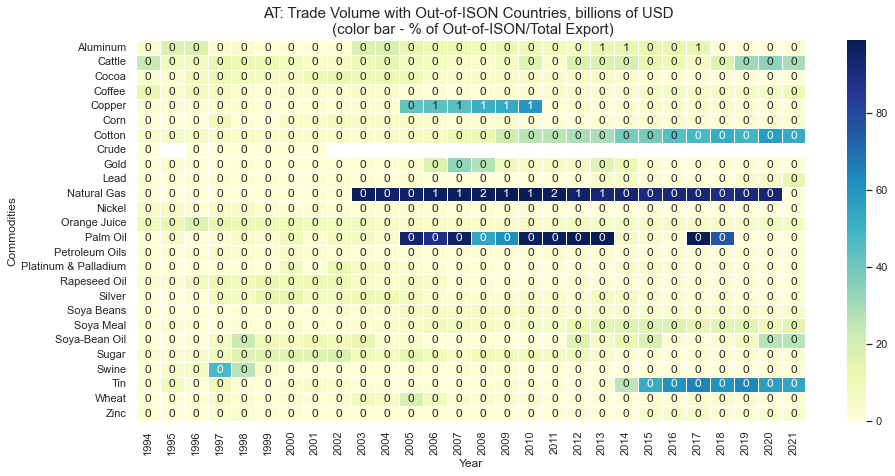

In [57]:
### STATS: DIFFERENCE BETWEEN WORLD AND ISON EXPORT: COUNTRY DETALIZATION, PARAMETERS TO CHOOSE

### Country slice
str_country = 'AT'#'US' #'OM' #'KW'
### Dates and commodities full lists:
idx_dates = sorted(df_comm_full['Date'].unique())
idx_comm = sorted(df_comm_full['Commodity_Name'].unique())
idx_full = pd.MultiIndex.from_product([idx_dates, idx_comm], names = ['Date', 'Commodity_Name'])
### ISON total trade:
ser_comm_ison = df_comm_full.groupby(['Date', 'Reporter', 'Commodity_Name'])['Value'].sum()#.dropna()
ser_comm_ison.name = 'Total_ISON'
### Difference caclulating:
ser_comm_world = df_comm_world.set_index(['Date', 'Reporter', 'Commodity_Name'])['Value']
ser_comm_world.name = 'World'
### Container for different comparision metrics:
dict_comm_compare = {}
dict_title_suffix = {}
### Comparision by proportion, %:
df_comm_compare = pd.concat([ser_comm_world, ser_comm_ison], axis = 1).dropna() / 1000000000
df_comm_compare['Not_covered'] = (1 - df_comm_compare['Total_ISON'] / df_comm_compare['World']).clip(lower = 0.0) * 100
df_comm_compare = df_comm_compare['Not_covered'].unstack('Reporter').reindex(idx_full).stack('Reporter').reset_index()
df_comm_compare.rename({0: 'Not_Covered'}, axis = 1, inplace = True)
df_comm_compare['Year'] = df_comm_compare['Date'].dt.year
dict_comm_compare['Proportion'] = df_comm_compare
dict_title_suffix['Proportion'] = '% of Out-of-ISON/Total Export'
### Comparision by value:
df_comm_compare = pd.concat([ser_comm_world, ser_comm_ison], axis = 1).dropna() / 1000000000
df_comm_compare['Not_covered'] = (df_comm_compare['World'] - df_comm_compare['Total_ISON']).clip(lower = 0.0)
df_comm_compare = df_comm_compare['Not_covered'].unstack('Reporter').reindex(idx_full).stack('Reporter').reset_index()
df_comm_compare.rename({0: 'Not_Covered'}, axis = 1, inplace = True)
df_comm_compare['Year'] = df_comm_compare['Date'].dt.year
dict_comm_compare['Value'] = df_comm_compare
dict_title_suffix['Value'] = 'Trade Volume with Out-of-ISON Countries, billions of USD'
### Comparision by partners number:
ser_comm_compare = df_comm_full.groupby(['Date', 'Commodity_Name', 'Reporter'])['Value'].count().astype(int)
df_comm_compare = ser_comm_compare.unstack('Reporter').reindex(idx_full).stack('Reporter').reset_index()
df_comm_compare.rename({0: 'Not_Covered'}, axis = 1, inplace = True)
df_comm_compare['Year'] = df_comm_compare['Date'].dt.year
dict_comm_compare['Partners'] = df_comm_compare
dict_title_suffix['Partners'] = 'Number of ISON Partners'
### Options selecting:
str_colors = 'Proportion'

str_labels = 'Value' # 'Value' # 'Partners'
### Tables loading:
df_colors = dict_comm_compare[str_colors]
df_labels = dict_comm_compare[str_labels]
### Data table preparation:
df_to_plot = df_colors.loc[df_colors['Reporter'] == str_country].set_index(['Commodity_Name', 'Year'])['Not_Covered'].unstack('Year').sort_index()
#int_max = max(int(df_to_plot.max().max()), 100)
int_max = int(df_to_plot.max().max())
df_to_annot = df_labels.loc[df_labels['Reporter'] == str_country].set_index(['Commodity_Name', 'Year'])['Not_Covered'].unstack('Year').sort_index()
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(data = df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = df_to_annot,
                         fmt = '0.0f', center = int_max // 2, vmin = 0, vmax = int_max)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Commodities')
ax_heatmap.set_title(str_country + ': ' + dict_title_suffix[str_labels] + ' \n (color bar - ' + dict_title_suffix[str_colors] + ')', 
                     fontsize = 15)
plt.yticks(rotation = 0)
plt.show()

(Flow in str_flow) & (Partner in str_partner) & (Flag in str_flag)


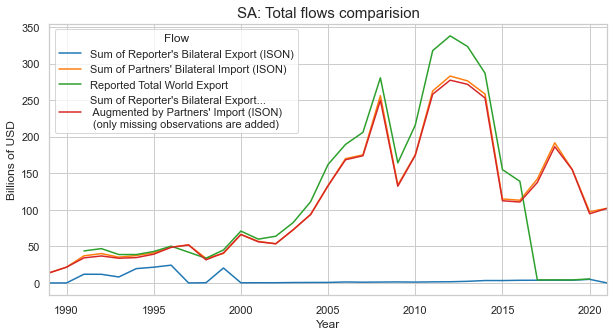

SA : Export observations count: 6402
SA : Export total, billions of USD: 158.59
SA : Inverted Import observations count: 11639
SA : Inverted Import total, billions of USD: 3794.48
SA : Export added with inverted import observations count: 13926
SA : Sum of Export added with inverted import observations, billions of USD: 3730.46
SA : Sum of World export total, billions of USD: 3526.61


In [56]:
### EXAMPLE: IMPORT ANALYSIS: DATA PREPARATION

gc.collect()
### Country to slice:
str_country = 'SA' #'CY' #'AU'      # 'US' # 'SA' # 
### Import bilateral data loading and inverting:
df_import = get_comtrade_data(str_flow = 'Import', str_flag = [0, 1], str_partner = str_country).reset_index()
df_import_inverted = df_import[['Date', 'Partner', 'Reporter', 'Commodity_Name', 'Value']]
df_import_inverted.columns = ['Date', 'Reporter', 'Partner', 'Commodity_Name', 'Value']
ser_import_inverted = df_import_inverted.set_index(['Date', 'Partner', 'Commodity_Name'])['Value']
ser_import_inverted.name = 'Import_Inverted'
### Aggregating with bilateral Export data:
ser_export = df_comm_full.set_index(['Date', 'Reporter', 'Partner', 'Commodity_Name'])['Value']
ser_export.name = 'Export'
ser_export = ser_export.loc[All, str_country, All, All]
df_flows_compare = pd.concat([ser_export, ser_import_inverted], axis = 1).sort_index()
df_flows_total = (df_flows_compare.groupby('Date').sum()/ 1000000000)
df_flows_total.columns = ['Sum of Reporter\'s Bilateral Export (ISON)', 'Sum of Partners\' Bilateral Import (ISON)']
### Aggregating with world Export data:
ser_world_export = df_comm_world.groupby(['Date', 'Reporter'])['Value'].sum().loc[All, str_country] / 1000000000
ser_world_export.name = 'Reported Total World Export'
df_flows_total = df_flows_total.join(ser_world_export)
### Aggregating with Export combined with inverted Import data:
ser_export_augmented = ser_export.combine_first(ser_import_inverted).groupby('Date').sum() / 1000000000
ser_export_augmented.name = 'Sum of Reporter\'s Bilateral Export...\n Augmented by Partners\' Import (ISON) \n (only missing observations are added)'
df_flows_total = df_flows_total.join(ser_export_augmented)
### Preparing to plot:
df_to_plot = df_flows_total.reset_index() 
df_to_plot['Year'] = df_to_plot['Date'].dt.year
df_to_plot.drop('Date', axis = 1, inplace = True)
df_to_plot = df_to_plot.melt(id_vars = ['Year'], var_name = 'Flow', value_name = 'Value')
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_flows = sns.lineplot(data = df_to_plot, x = 'Year', y = 'Value', hue = 'Flow')
ax_flows.set_title(str_country + ': Total flows comparision', fontsize = 15)
ax_flows.set(xlim = (1989, 2021), ylabel = 'Billions of USD')
plt.show()


### EXAMPLE STATISTICS: COMPLETING EXPORT WITH IMPORT OBSERVATIONS
print(str_country, ': Export observations count:', ser_export.count())
print(str_country, ': Export total, billions of USD:', (ser_export.sum() / 1000000000).round(2))
print(str_country, ': Inverted Import observations count:', ser_import_inverted.count())
print(str_country, ': Inverted Import total, billions of USD:', (ser_import_inverted.sum() / 1000000000).round(2))
print(str_country, ': Export added with inverted import observations count:', ser_export.combine_first(ser_import_inverted).count())
print(str_country, ': Sum of Export added with inverted import observations, billions of USD:', 
      (ser_export.combine_first(ser_import_inverted).sum() / 1000000000).round(2))
print(str_country, ': Sum of World export total, billions of USD:', (ser_world_export.sum()).round(2))

In [ ]:
### WEIGHTED AVERAGE PRICE SIMULATION

### Weights calculation definition:
def get_weight(df_group):
    df_group['Weight'] = df_group['Value'] / df_group['Value'].sum()
    return df_group

### Weights calculation for each Date / Reporter pair:
df_comm_weight = df_comm_world.groupby(['Date', 'Reporter']).apply(get_weight)
ser_weight = df_comm_weight.set_index(['Date', 'Reporter', 'Commodity_ID'])['Weight']
ser_weight.name = 'Weight'

### Prices vector emulation:
list_rand_prices = list(np.random.rand(1, len(ser_weight))[0])
ser_price = pd.Series(list_rand_prices, index = ser_weight.index)
ser_price.name = 'Price'

### Average price calculation:
df_to_mean = ser_price.to_frame().join(ser_weight)
ser_mean_price = df_to_mean.dropna().groupby(['Date', 'Reporter']).apply(lambda df_group: (df_group['Price'] * df_group['Weight']).sum() / df_group['Weight'].sum())

In [ ]:
### TEMP

ser_mean_price